## **Unsupervised ML approach to cluster mental health cases**
This uses an unsupervised ML approach to dentifying mental health cases related to the climate variables (q, t2m, uvbed(UV) and uvbedcs(UV clear sky) and associated thresholds leading to these events.

Note: Many health conditions are shaped by factors beyond climate -- such as genetics, lifestyle, socio-economic status, and healthcare access--making it difficult to isolate climate as the primary influence in many clinical cases.

In [42]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

### 1. Data Loading and Preprocessing

#### Read Data

In [2]:
#### read the climate_health data
df = pd.read_csv(
    "dataset/health_climate_2018_2020.csv", 
    parse_dates=["incident_time"]
)

#### Compute temporal features

In [3]:
# compute temporal features based on incident_time
# Seasonality = patterns that repeat over a known cycle, usually time-based. For climate
# ==============================================================
# Humidity	--> Higher in cooler/wetter months (Winter/Spring)
# Temperature --> Peaks in Summer, drops in Winter
# uvbed --> Higher in Summer, lower in Winter
# uvbedcs --> Also peaks with sunlight exposure (clear skies, Summer)
# ==============================================================
def get_days_in_year(year):
    return 366 if calendar.isleap(year) else 365
        
def temporal_cyclical_features(df, time_col='incident_time'):
    df = df.copy()

    # Convert the time column to datetime if not already
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col])

    # Extract temporal features
    df['DayOfYear'] = df[time_col].dt.dayofyear                 # Day of the year (1-365/366)
    df['Month'] = df[time_col].dt.month                         # Month of the year (1-12)
    df['WeekOfYear'] = df[time_col].dt.isocalendar().week
    df['WeekOfYear'] = df['WeekOfYear'].apply(lambda x: x if x <= 52 else 52)  # Handle Week 53 cases by mapping them to 52
 
    # Determine the season (0: Winter, 1: Spring, 2: Summer, 3: Fall)
    df['Season'] = df[time_col].apply(lambda x: 
        0 if x.month in [12, 1, 2] else 
        1 if x.month in [3, 4, 5] else 
        2 if x.month in [6, 7, 8] else 
        3
    )
    return df


df = temporal_cyclical_features(df, time_col='incident_time')

#### Select Required Season
In computing temporal features, summer months are assigned a season value of 2, assuming they represent the warm months.

In [4]:
# ONLY Summer Season require for the exploration
# We want to determine climatic effects on clinical categories in the 
# summer days, which is know to have high tempperatures.
# ========================================================
df = df[df['Season']==2] # 2= summer 

#### Filter Dataset by Mental Health
We need only mental health data so we will select that from the dataset

In [5]:
mh_df = df[df['clinical_category'] == '(Mental Health)']

### Drop NANs
K-Means and XGBoost cannot handle NaNs directly, so we must remove them

In [6]:
mh_df = mh_df.dropna() #Drop Nans

## Unsupervised Learning: SpectralClustering with K-Mean
We apply `SpectralClustering` with `K-Means` to analyse mental health cases, using climate variables (temperature, humidity, UV radiation) to identify meaningful, interpretable clusters for policy insights.

In [7]:
climate_features = ['q', 't2m', 'uvbed', 'uvbedcs']
X = StandardScaler().fit_transform(mh_df[climate_features])

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans')
mh_df_cluster = mh_df.copy()
mh_df_cluster.loc[:, 'cluster'] = spectral.fit_predict(X)

### Compute Cluster Summary
This code groups data by `cluster`, calculates counts and means of selected features, and outputs a summary `DataFrame` with `reset_index()` for `cluster`.

In [8]:
# # Get counts and means per cluster
# cluster_summary = mh_df_cluster.groupby('cluster').agg(
#     q_mean=('q', 'mean'),       # Mean of 'q'
#     t2m_mean=('t2m', 'mean'),   # Mean of 't2m'
#     uvbed_mean=('uvbed', 'mean'), # Mean of 'uvbed'
#     uvbedcs_mean=('uvbedcs', 'mean'), # Mean of 'uvbedcs'
#     count=('cluster', 'size')  # Count the number of items per cluster
# ).reset_index()

# Get counts and means per cluster, and calculate percentage of total
cluster_summary = mh_df_cluster.groupby('cluster').agg(
    q_mean=('q', 'mean'),        
    t2m_mean=('t2m', 'mean'),  
    uvbed_mean=('uvbed', 'mean'), 
    uvbedcs_mean=('uvbedcs', 'mean'),
    count=('cluster', 'size')    
).reset_index()

# Add count percentage and drop the count column
cluster_summary['% of samples'] = ((cluster_summary['count'] / cluster_summary['count'].sum()) * 100).round(2)
cluster_summary = cluster_summary.drop(columns=['count'])


In [9]:
cluster_summary

cluster    q_mean    t2m_mean  uvbed_mean  uvbedcs_mean  % of samples
0        0  0.008820  292.429536    0.091521      0.151727         89.91
1        1  0.009007  291.290192    0.081828      0.138627          0.64
2        2  0.008757  292.141918    0.087498      0.155337          9.45

### Explore Demographics on Clusters 

#### Create "Sex" Subclusters

In [10]:
mh_df_cluster['subcluster'] = (
    "C" + mh_df_cluster['cluster'].astype(str) + 
    " | " + mh_df_cluster['sex'].fillna("Unknown") 
)

 #### Count and Profile Subclusters

In [11]:
subcluster_counts = mh_df_cluster['subcluster'].value_counts()

In [12]:
# # Group by 'cluster' and count 'subcluster' occurrences
# subcluster_counts = (
#     mh_df_cluster.groupby('cluster')['subcluster']
#     .value_counts()
#     .groupby(level=0, group_keys=False)
#     .head(10)
# )

# # Optional: convert to DataFrame for nicer display
# subcluster_counts = subcluster_counts.reset_index(name='count')
# print(subcluster_counts)

# Group by 'cluster' and 'subcluster', then count 'subcluster' occurrences
subcluster_counts = (
    mh_df_cluster.groupby(['cluster', 'subcluster'])
    .size()
    .groupby(level=0, group_keys=False)
    .head(10)
)

# Calculate the percentage based on the overall total number of samples
total_samples = len(mh_df_cluster)  # Total number of samples in the dataset
subcluster_counts = subcluster_counts.reset_index(name='count')
subcluster_counts['% of samples'] = (subcluster_counts['count'] / total_samples) * 100

# Round the percentage to 2 decimal places
subcluster_counts['% of samples'] = subcluster_counts['% of samples'].round(2)

# Order first by 'subcluster', then by '% of samples'
subcluster_counts = subcluster_counts.drop(columns=['count']).sort_values(by=['subcluster', '% of samples'], ascending=[True, False])


In [13]:
subcluster_counts

cluster          subcluster  % of samples
0         0          C0 | Blank          0.01
1         0         C0 | Female         51.00
2         0           C0 | Male         38.37
3         0      C0 | Not Known          0.21
4         0  C0 | Not Specified          0.05
5         0    C0 | Transgender          0.27
6         1         C1 | Female          0.35
7         1           C1 | Male          0.29
8         2          C2 | Blank          0.00
9         2         C2 | Female          5.33
10        2           C2 | Male          4.06
11        2      C2 | Not Known          0.01
12        2  C2 | Not Specified          0.01
13        2    C2 | Transgender          0.03

### Decision Tree to Interprete Subclusters

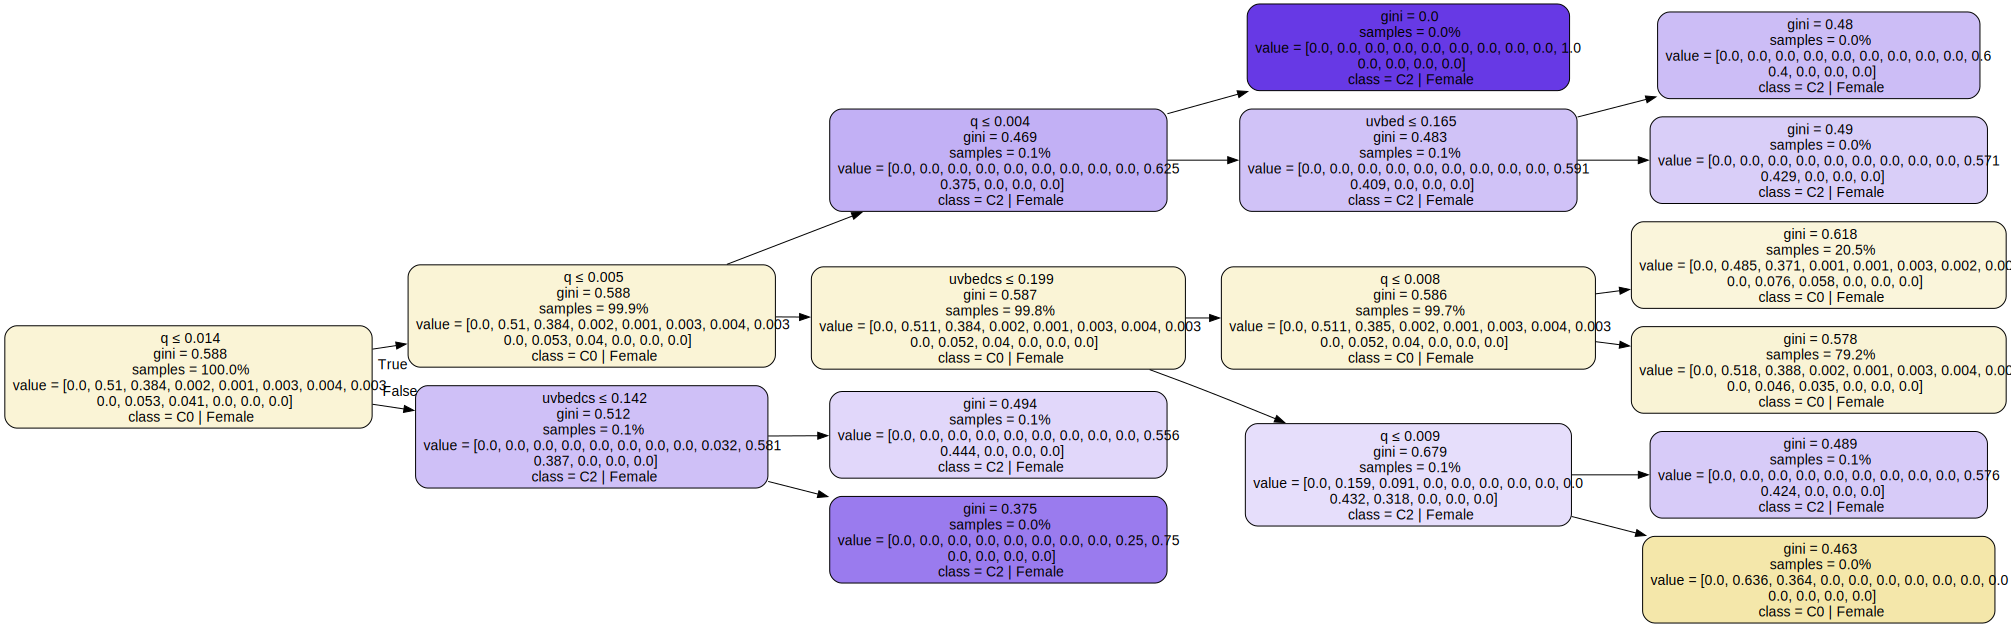

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
import graphviz
from IPython.display import display, SVG

# Encode subclusters
le = LabelEncoder()
mh_df_cluster['subcluster_id'] = le.fit_transform(mh_df_cluster['subcluster'])

# Train tree
X = mh_df_cluster[['q', 't2m', 'uvbed', 'uvbedcs']]
y = mh_df_cluster['subcluster_id']
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X, y)

# Export DOT data
dot_data = export_graphviz(tree, 
                           feature_names=X.columns, 
                           class_names=le.classes_, 
                           filled=True, 
                           rounded=True, 
                           special_characters=True, 
                           proportion=True)

# Inject horizontal layout into DOT source
dot_data = dot_data.replace('digraph Tree {', 'digraph Tree {\nrankdir=LR;')

# Create Graphviz source and render as SVG
graph = graphviz.Source(dot_data, format="svg")
svg = graph.pipe().decode('utf-8')

# Display inline in JupyterLab
display(SVG(svg))


### Extract IF...Then rules from decision tree

In [15]:
from sklearn.tree import _tree

def extract_rules_from_tree(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Left child
            recurse(tree_.children_left[node], path + [f"{name} <= {threshold:.3f}"])
            # Right child
            recurse(tree_.children_right[node], path + [f"{name} > {threshold:.3f}"])
        else:
            value = tree_.value[node][0]
            class_id = value.argmax()
            class_name = class_names[class_id]
            rules.append((path, class_name, int(value[class_id])))

    recurse(0, [])
    return rules

def rules_to_text(rules):
    summaries = []
    for conditions, cluster_label, count in rules:
        rule_text = "\n  - " + "\n  - ".join(conditions)
        summary = f"IF:{rule_text}\nTHEN: {cluster_label} (n={count})"
        summaries.append(summary)
    return "\n\n".join(summaries)

# Example usage (assuming you've trained your decision tree):
rules = extract_rules_from_tree(tree, X.columns, le.classes_)
print(rules_to_text(rules))


IF:
  - q <= 0.014
  - q <= 0.005
  - q <= 0.004
THEN: C2 | Female (n=2)

IF:
  - q <= 0.014
  - q <= 0.005
  - q > 0.004
  - uvbed <= 0.165
THEN: C2 | Female (n=9)

IF:
  - q <= 0.014
  - q <= 0.005
  - q > 0.004
  - uvbed > 0.165
THEN: C2 | Female (n=4)

IF:
  - q <= 0.014
  - q > 0.005
  - uvbedcs <= 0.199
  - q <= 0.008
THEN: C0 | Female (n=3437)

IF:
  - q <= 0.014
  - q > 0.005
  - uvbedcs <= 0.199
  - q > 0.008
THEN: C0 | Female (n=14205)

IF:
  - q <= 0.014
  - q > 0.005
  - uvbedcs > 0.199
  - q <= 0.009
THEN: C2 | Female (n=19)

IF:
  - q <= 0.014
  - q > 0.005
  - uvbedcs > 0.199
  - q > 0.009
THEN: C0 | Female (n=7)

IF:
  - q > 0.014
  - uvbedcs <= 0.142
THEN: C2 | Female (n=15)

IF:
  - q > 0.014
  - uvbedcs > 0.142
THEN: C2 | Female (n=3)


### Supervised Model for Alert System

#### Prepare Features (Climate features) and Labels (alert)

In [26]:
X = mh_df_cluster[climate_features]  # Climate features
y = mh_df_cluster['cluster']  # Alert (2=High-risk, 1 = Moderate-risk, 0 = Low-risk)

#### OPTIONAL: Handle Imbalance in Dataset

In [27]:
# # Initialize undersampler
# undersampler = RandomUnderSampler(random_state=42)

# # Apply undersampling
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

####  Train/Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, 
    stratify=y, random_state=42
)

#### **ML: XGBClassifier**

In [30]:
params = {
    'objective': 'multi:softprob',
    'num_class': y_train.nunique(),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'eval_metric': 'mlogloss'
}

xgb_model = xgb.XGBClassifier(random_state=42)
# Train your model with updated parameters
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

#### Predict Results on Test Data

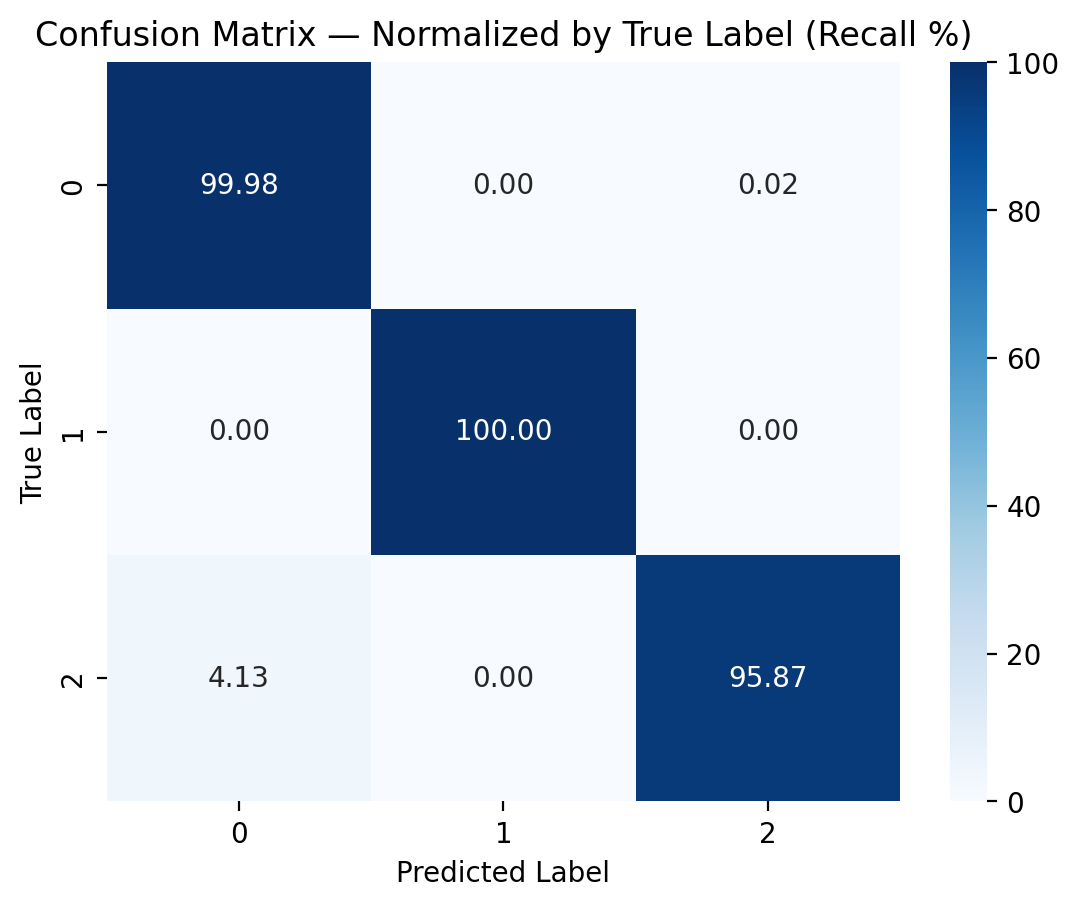

In [37]:
# Predict class probabilities
y_proba = xgb_model.predict_proba(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_proba, axis=1)

# If y_test is one-hot encoded, convert it back to integer labels
y_test = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test

# Step 8: Evaluation
label_names = ['0', '1', '2']


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize per row (true class) to match recall — each row sums to 100%
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",  # Percentages with 2 decimals
    xticklabels=label_names,
    yticklabels=label_names,
    cmap='Blues'
)
plt.title("Confusion Matrix — Normalized by True Label (Recall %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### Feature Importance

In [38]:
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': climate_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [39]:
feature_importance_df

feature  importance
1      t2m    0.259136
3  uvbedcs    0.255303
2    uvbed    0.253381
0        q    0.232179

### SHAP Analysis - See Which Variables Influence Each Class


 SHAP Summary Plot for Cluster: 0


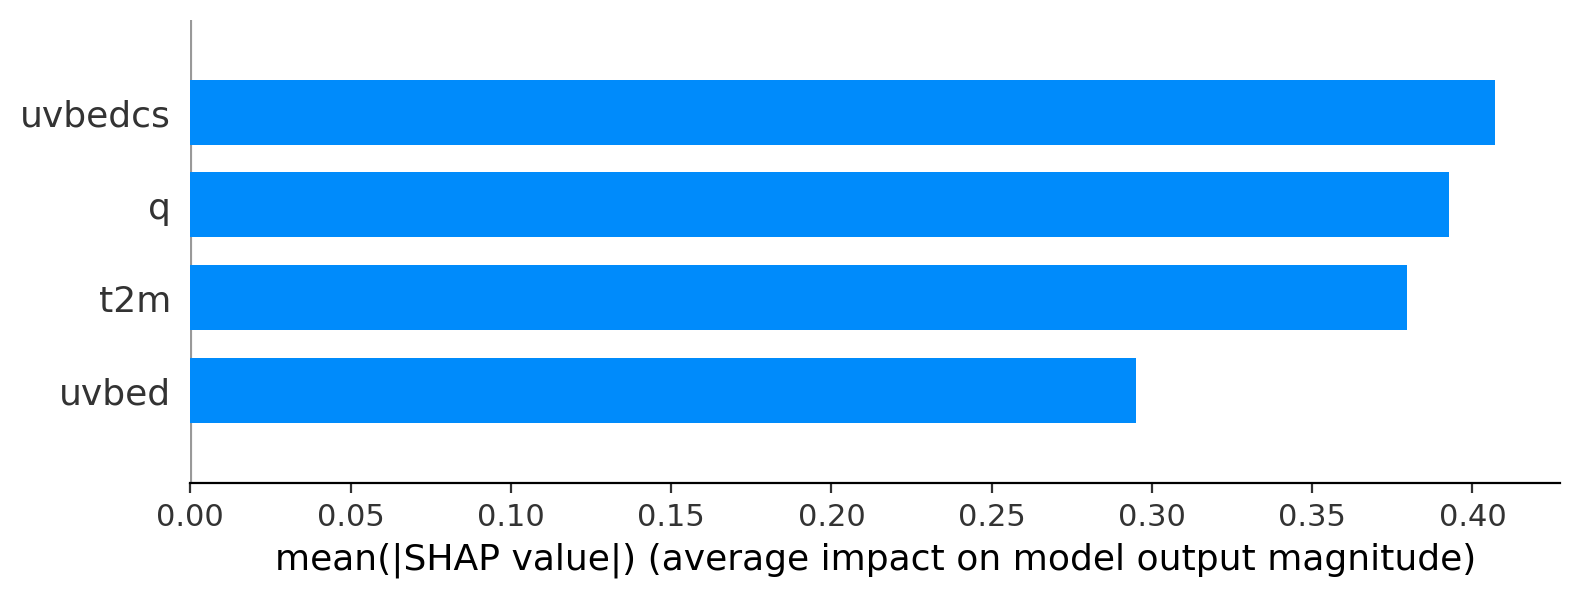

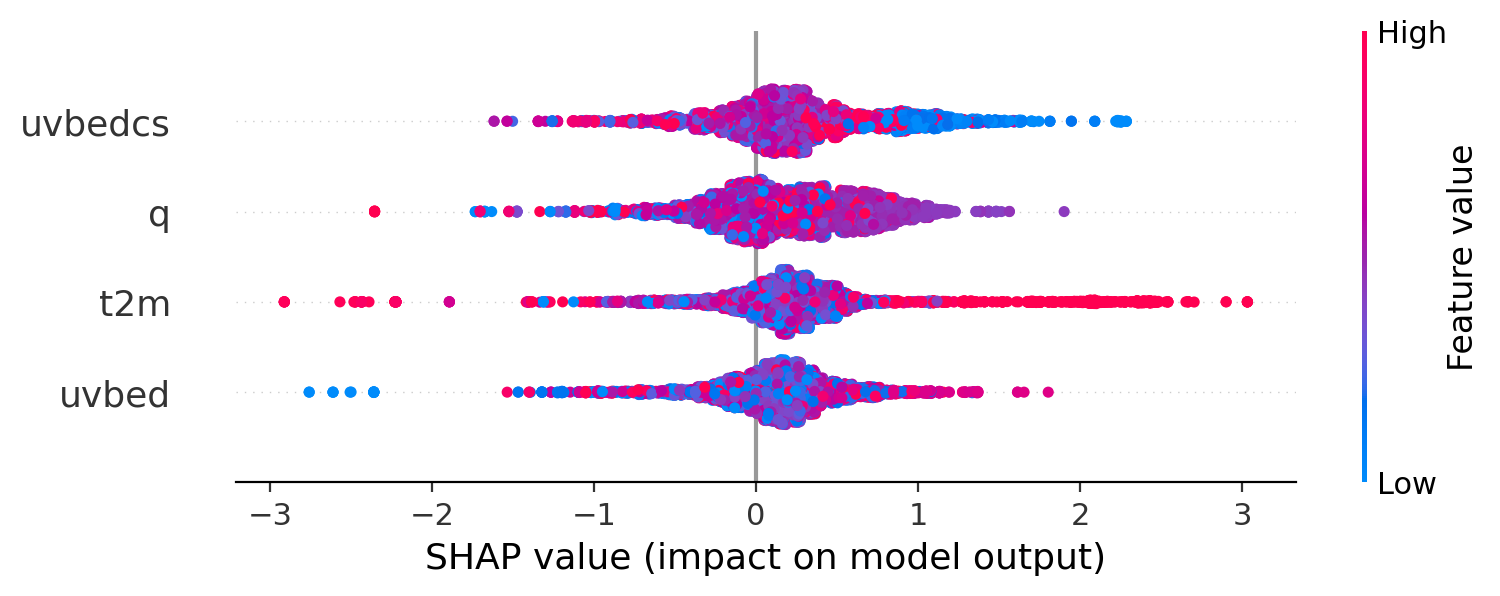


 SHAP Summary Plot for Cluster: 1


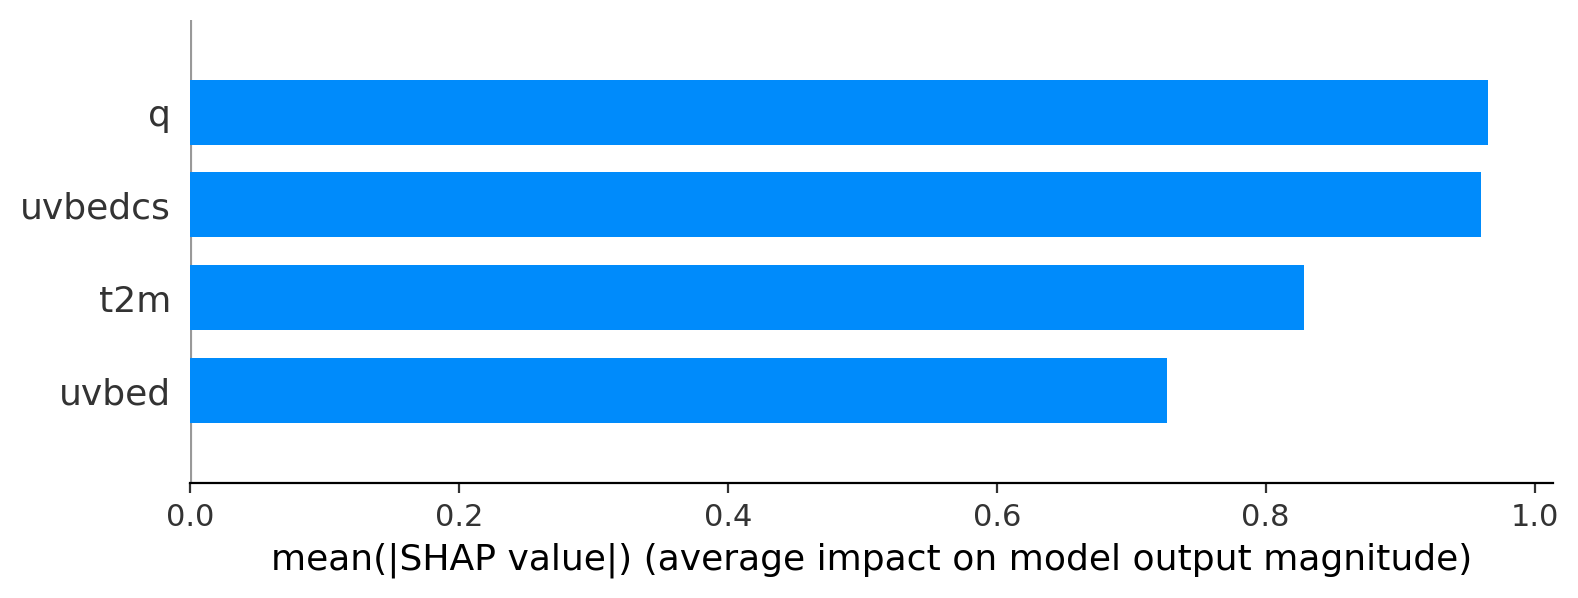

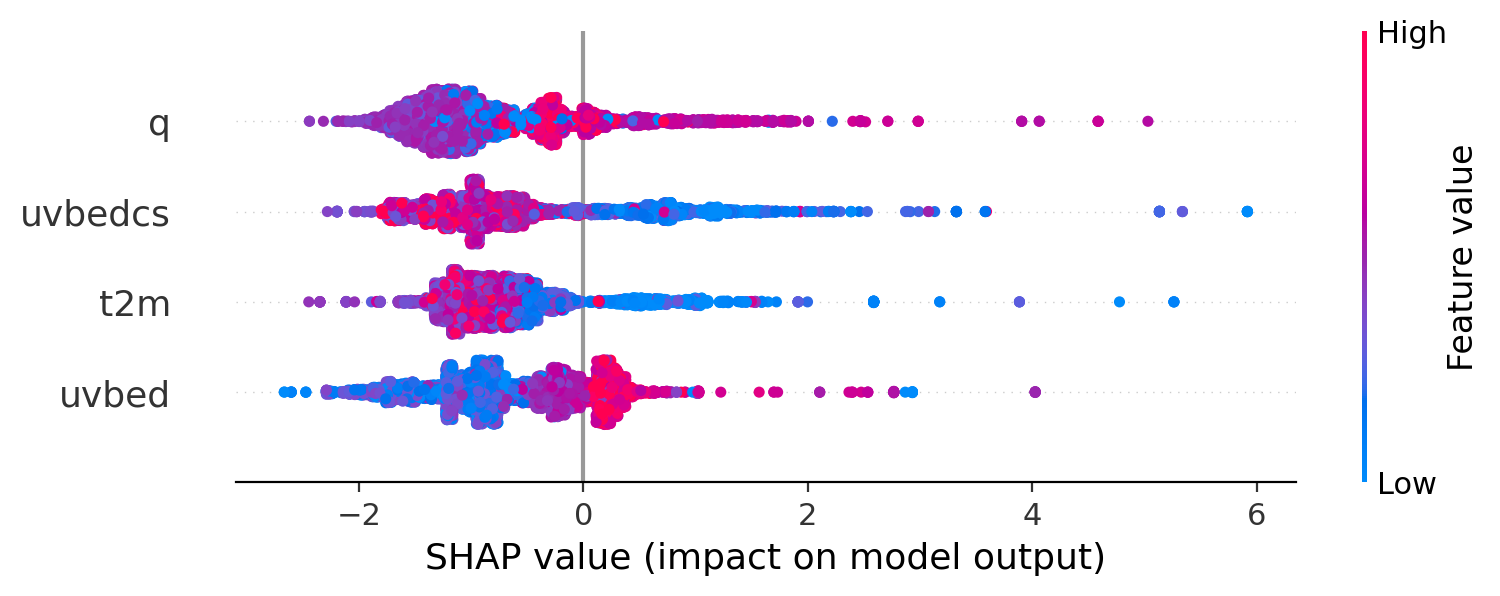


 SHAP Summary Plot for Cluster: 2


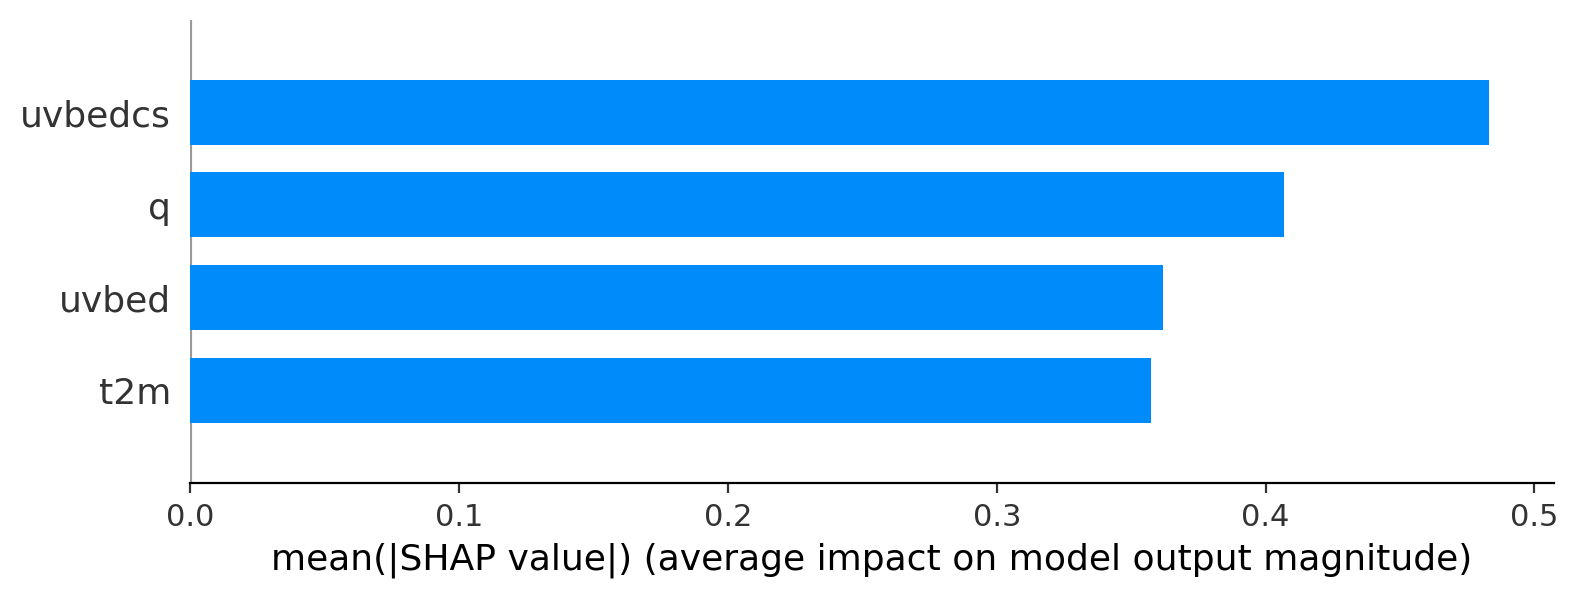

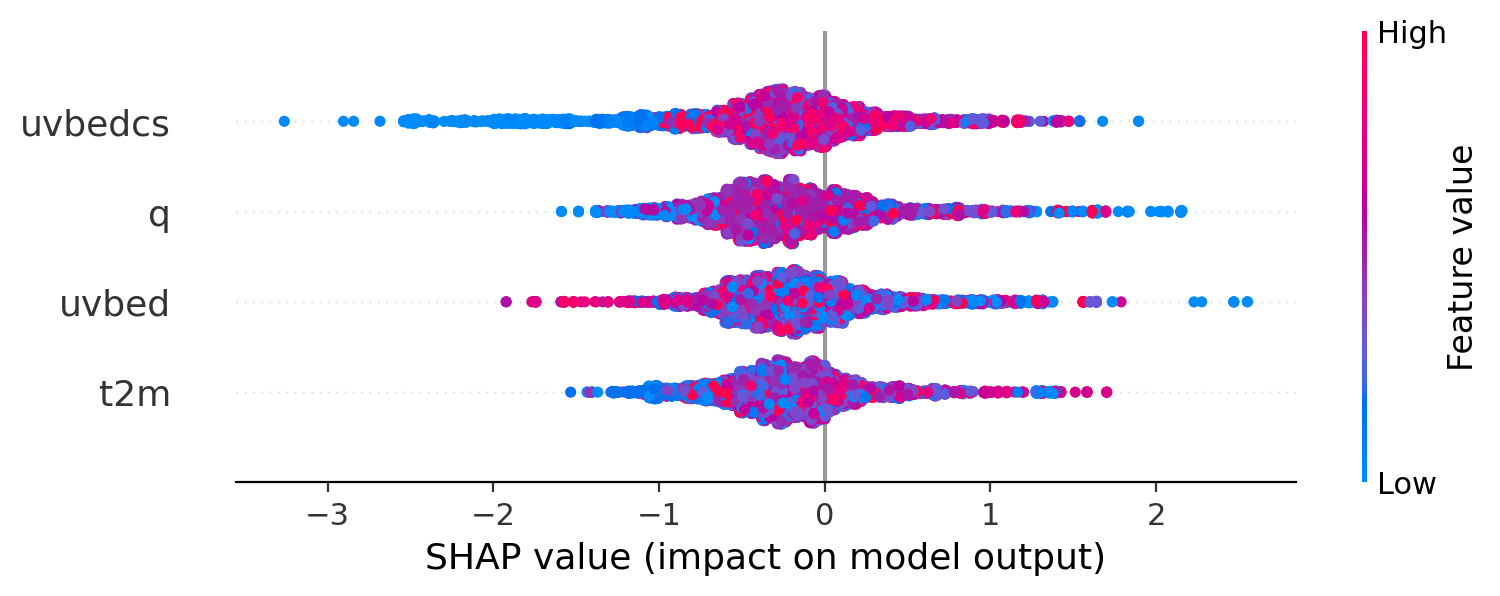

In [40]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Create TreeExplainer for your trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Step 3: Compute SHAP values
# Result shape: (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_test)

# Step 4: Transpose SHAP values to shape (n_classes, n_samples, n_features)
shap_values_transposed = np.transpose(shap_values, (2, 0, 1))

# Step 5: Define feature names and class labels
climate_features = ['q', 't2m', 'uvbed', 'uvbedcs']
X_climate = X_test[climate_features]
class_names = ['0', '1', '2']

# Step 6: Loop over each class and generate SHAP summary plots
for i, class_name in enumerate(class_names):
    print(f"\n SHAP Summary Plot for Cluster: {class_name}")
    
    # SHAP bar plot
    shap.summary_plot(shap_values_transposed[i], X_climate, plot_type="bar")
    
    # SHAP dot plot
    shap.summary_plot(shap_values_transposed[i], X_climate)


### Dependence Plots - Detect Climate Thresholds


 Dependence plots for Cluster: 0
Feature: t2m


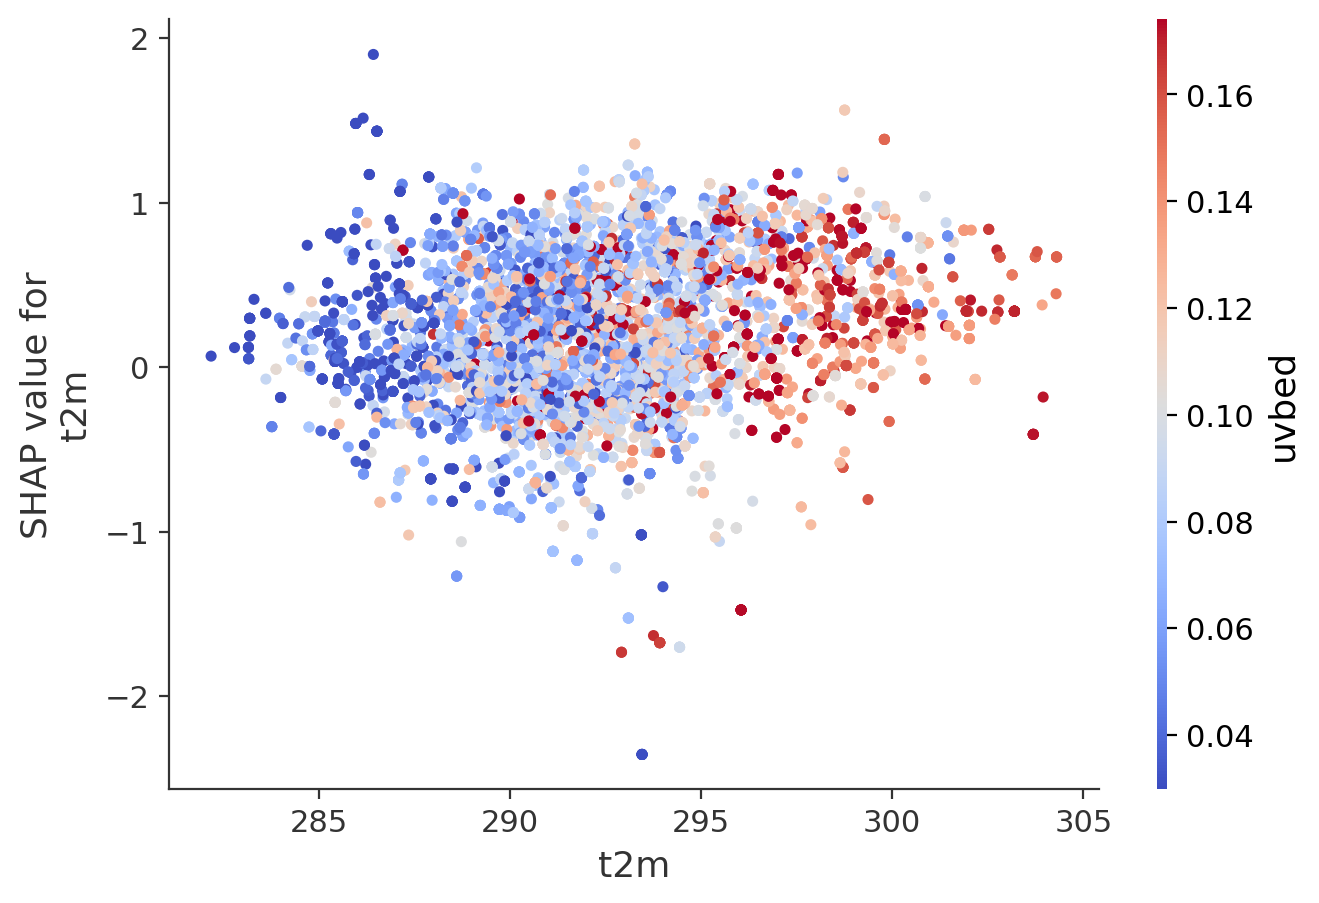

Feature: uvbed


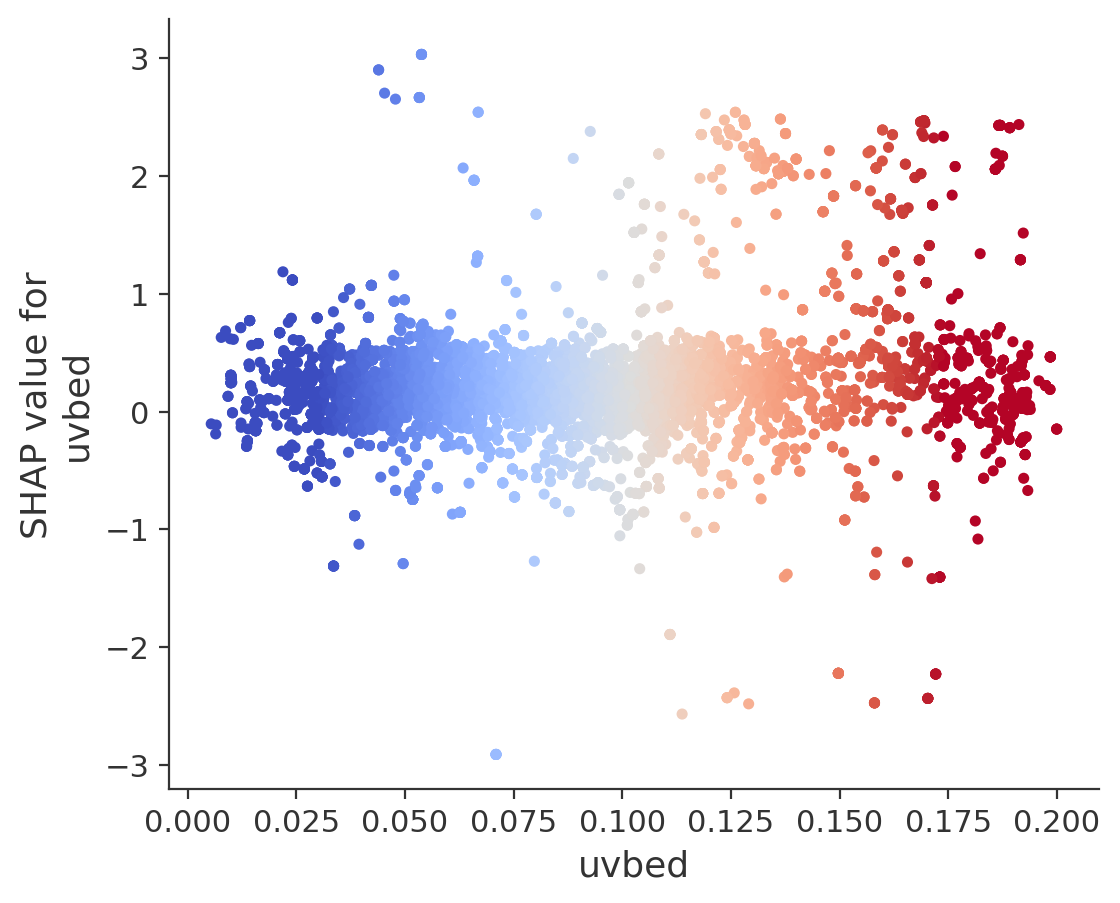

Feature: q


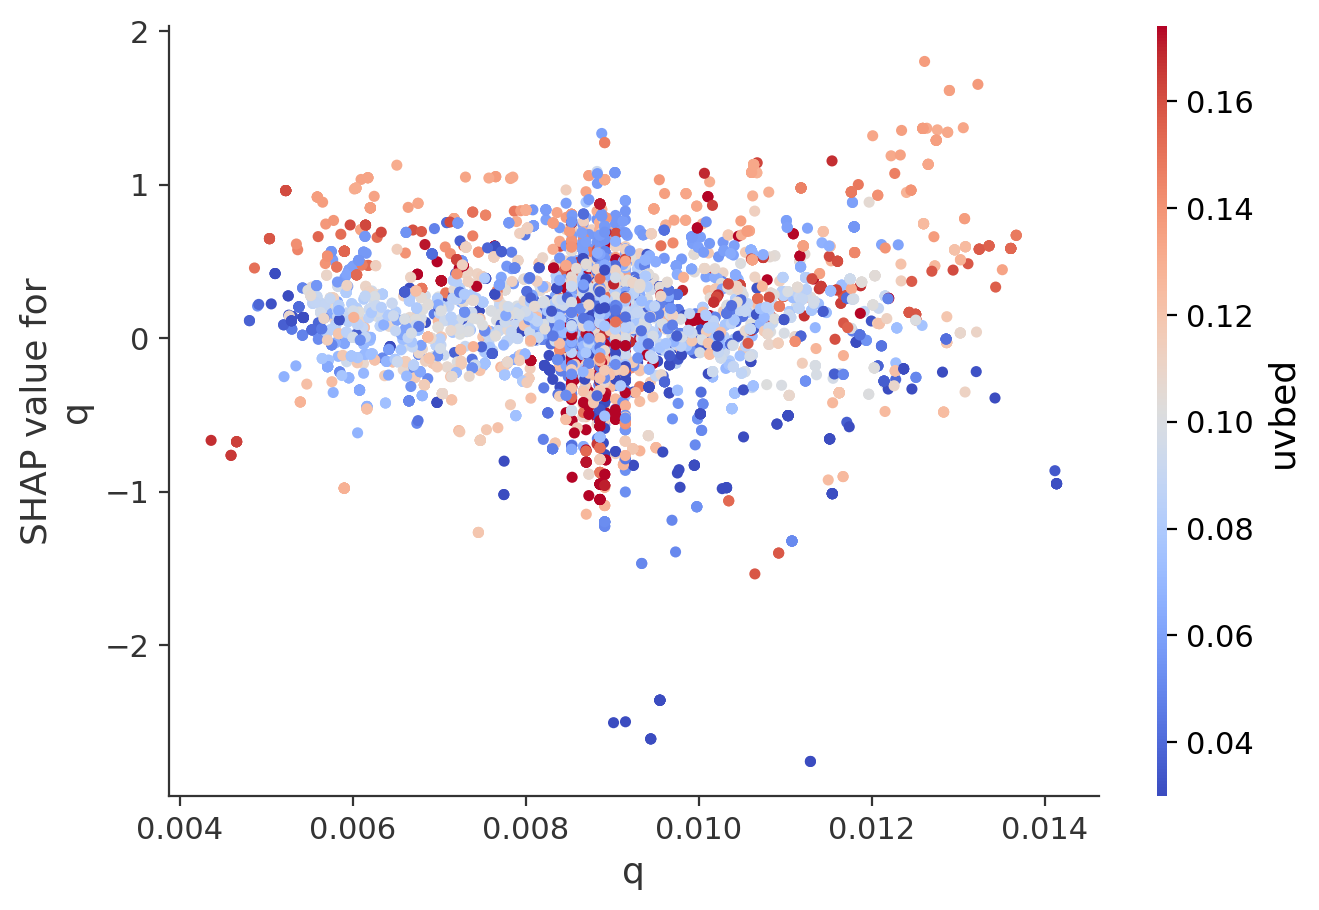

Feature: uvbedcs


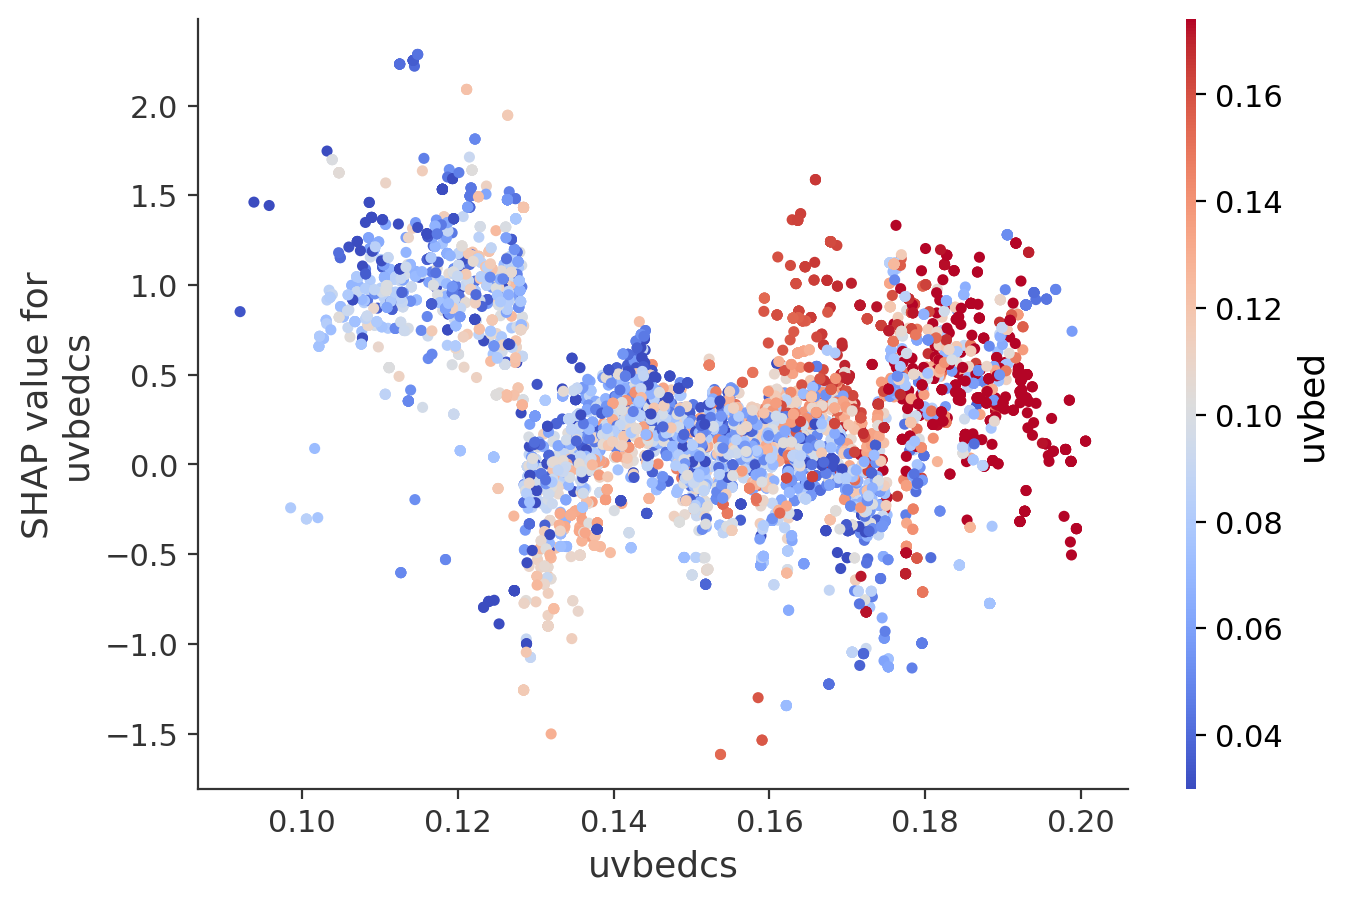


 Dependence plots for Cluster: 1
Feature: t2m


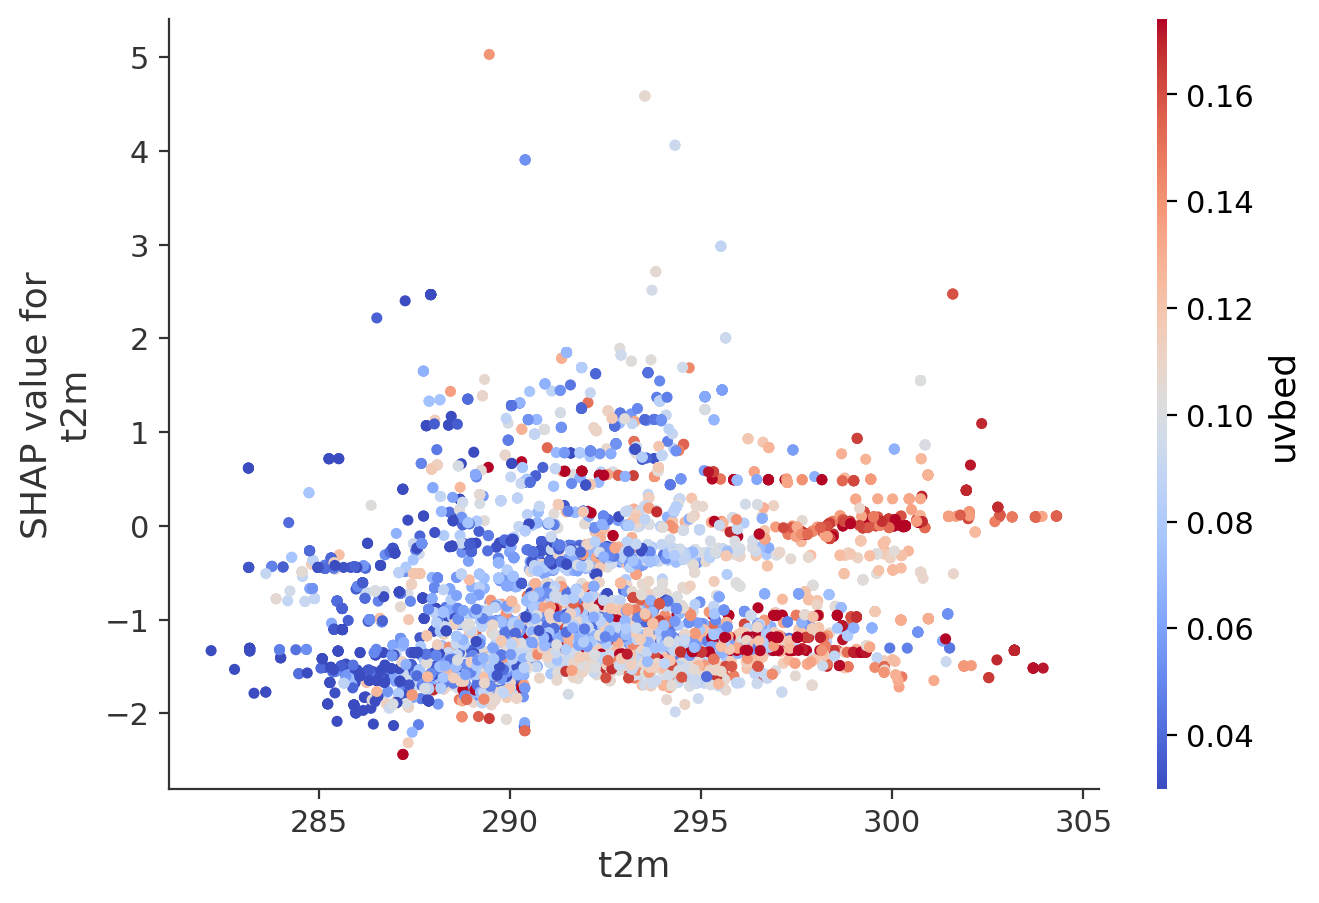

Feature: uvbed


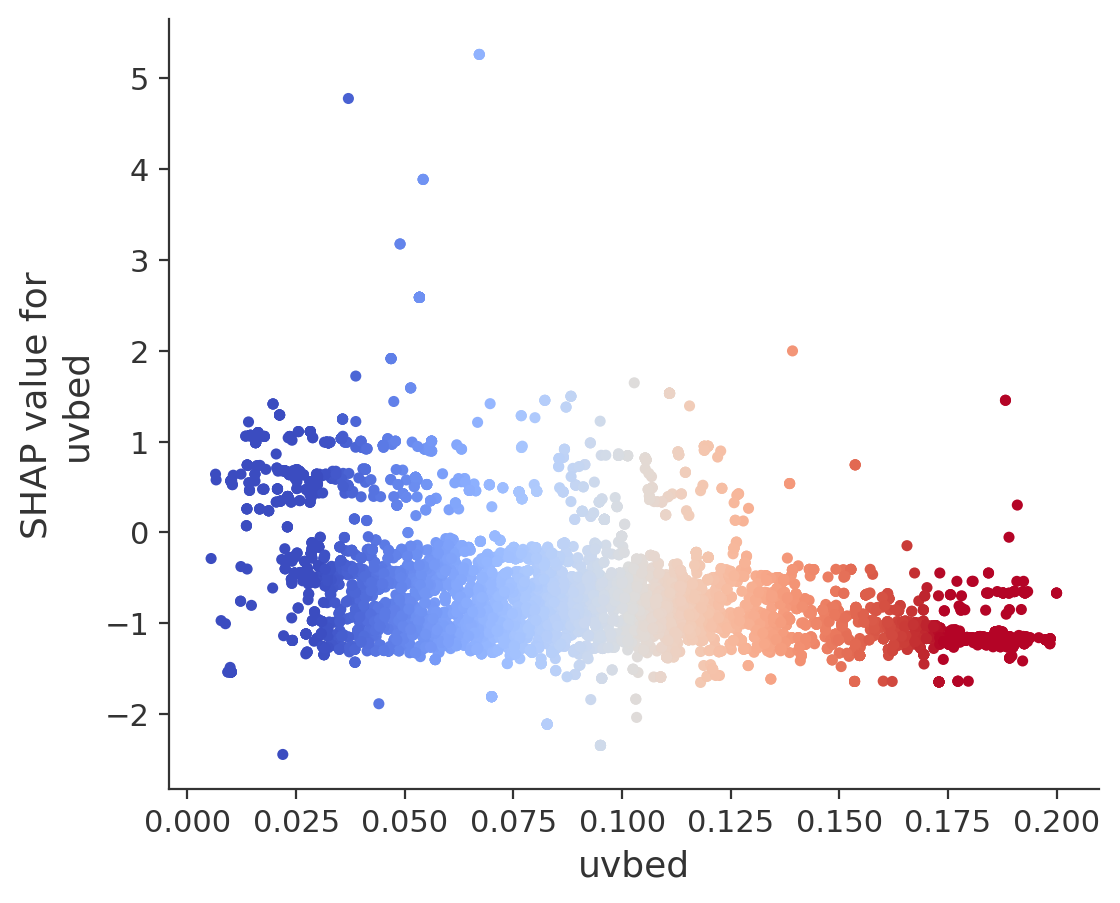

Feature: q


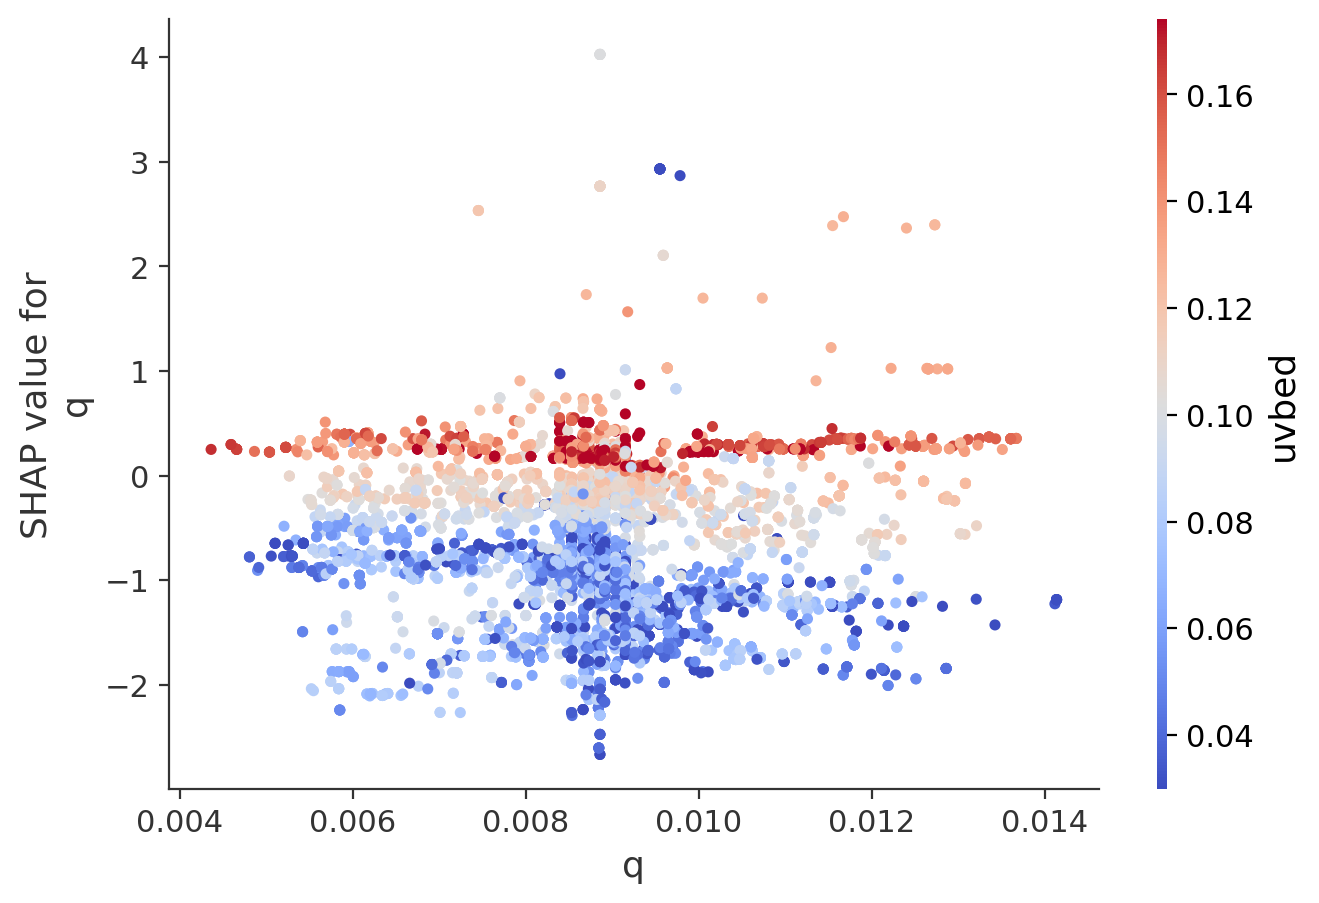

Feature: uvbedcs


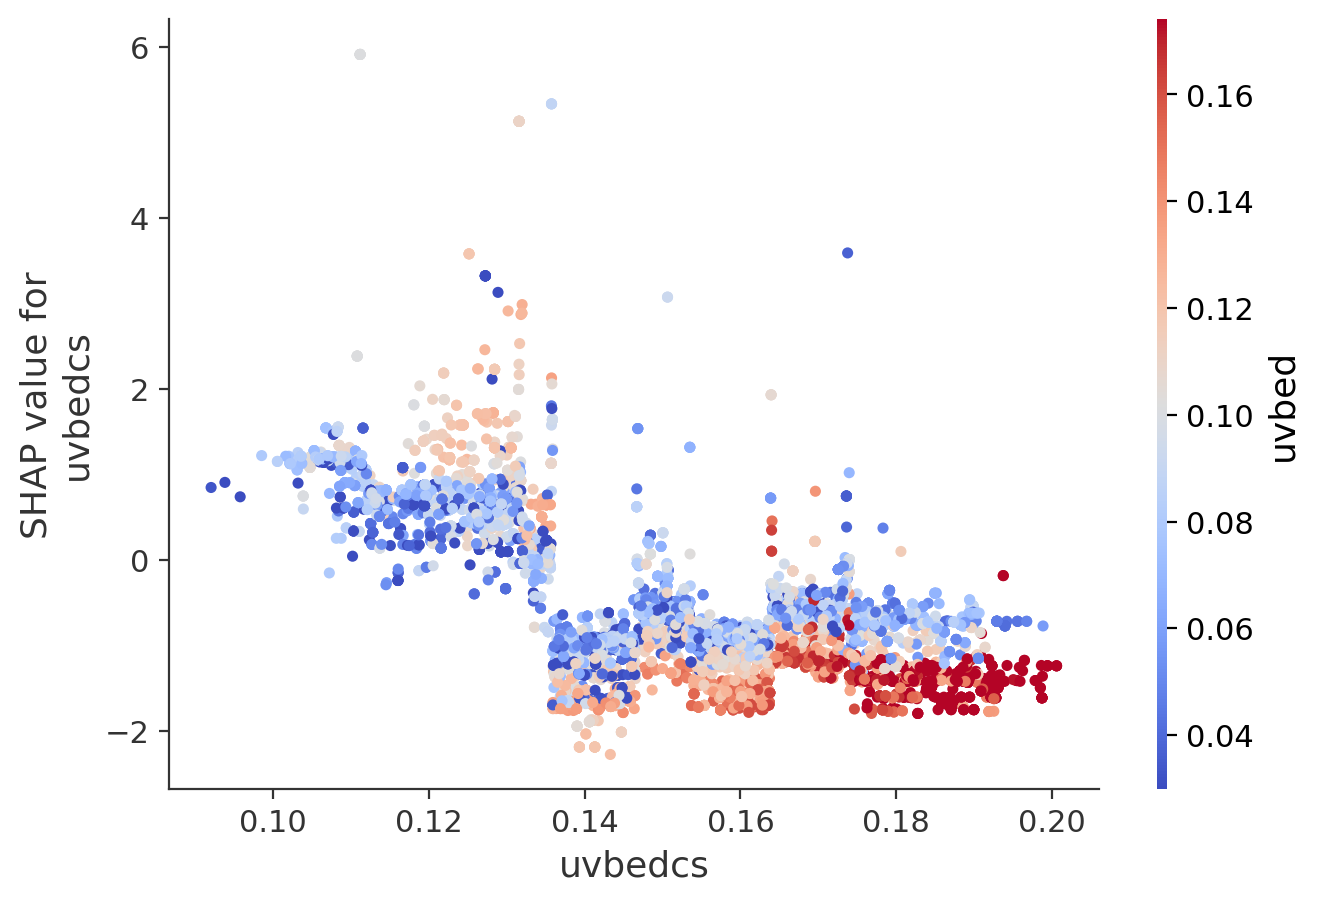


 Dependence plots for Cluster: 2
Feature: t2m


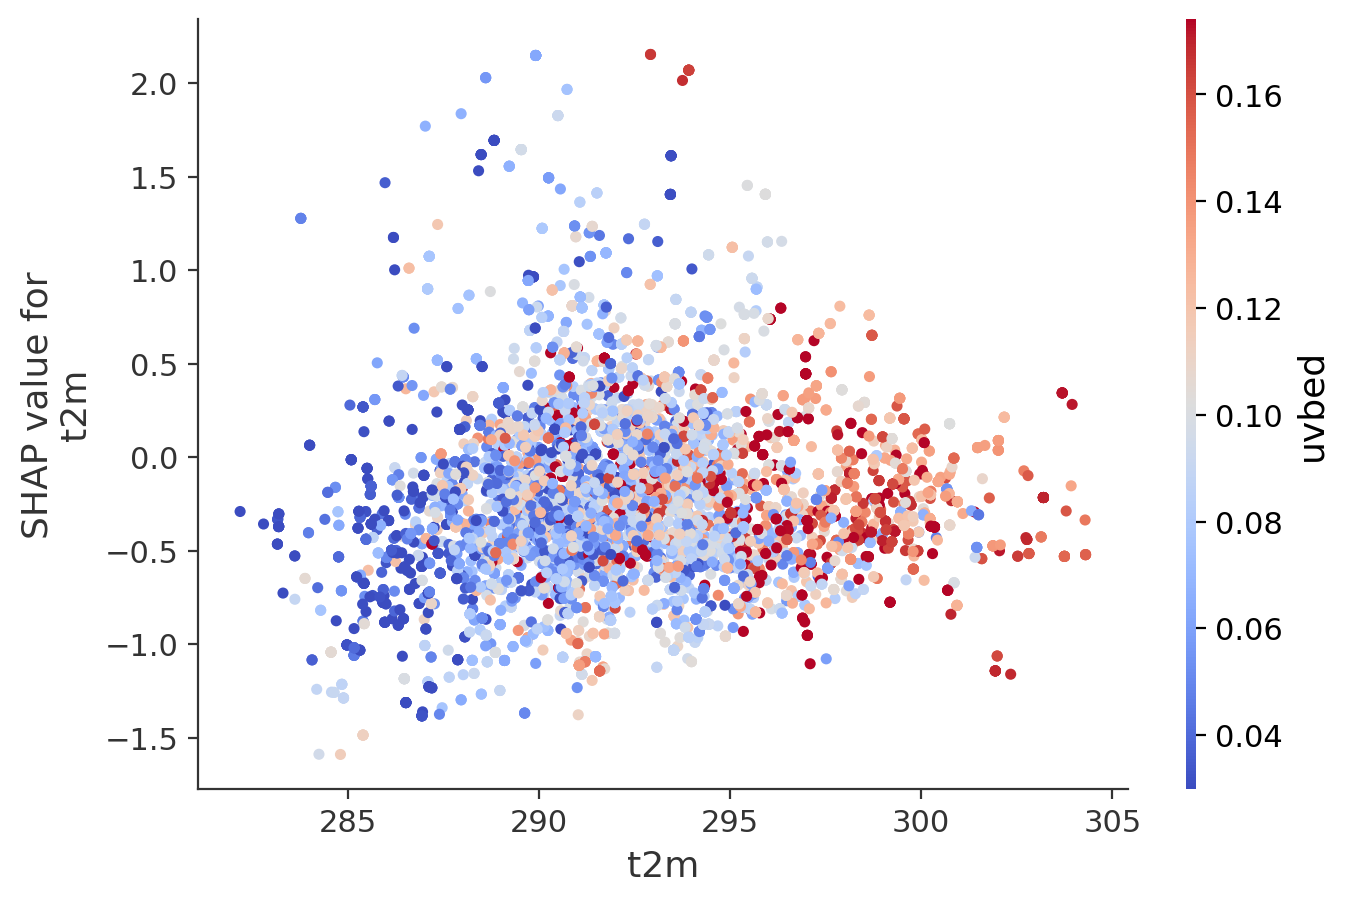

Feature: uvbed


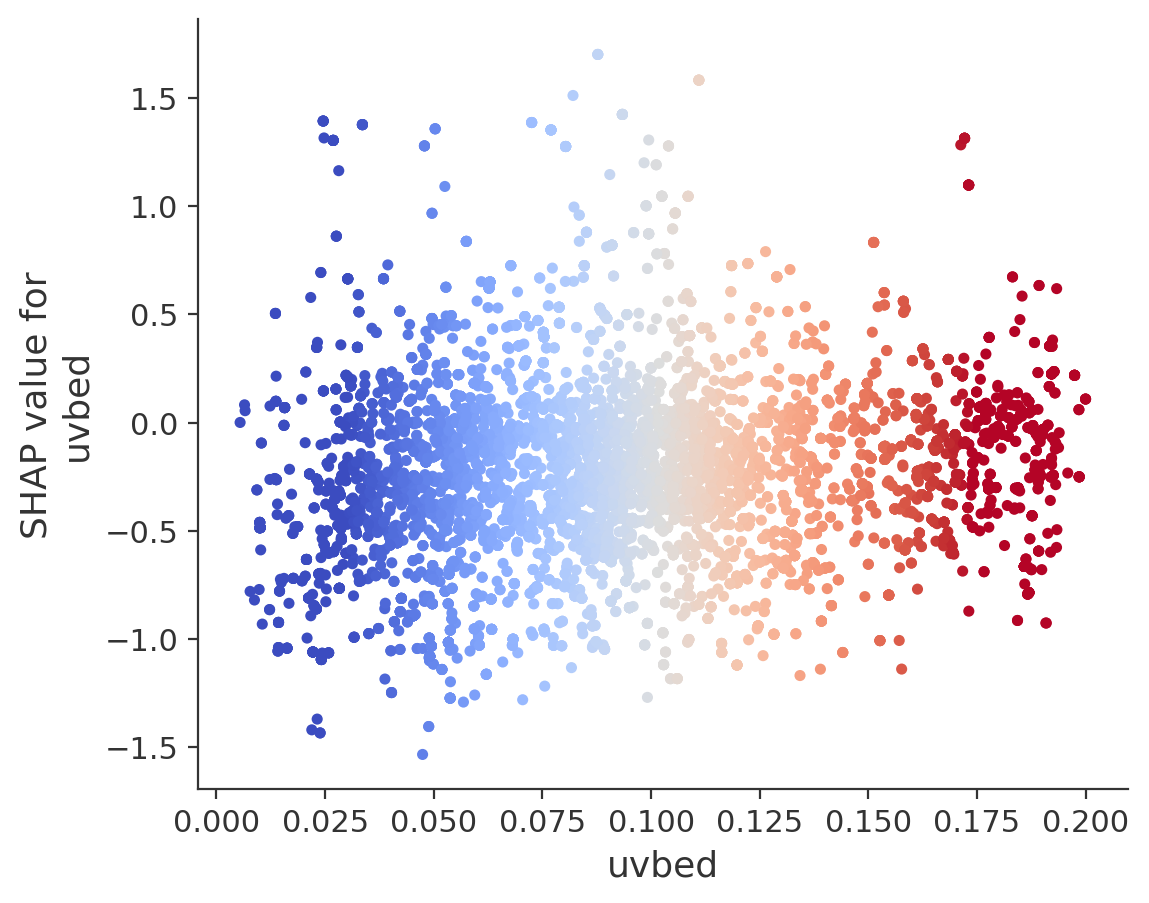

Feature: q


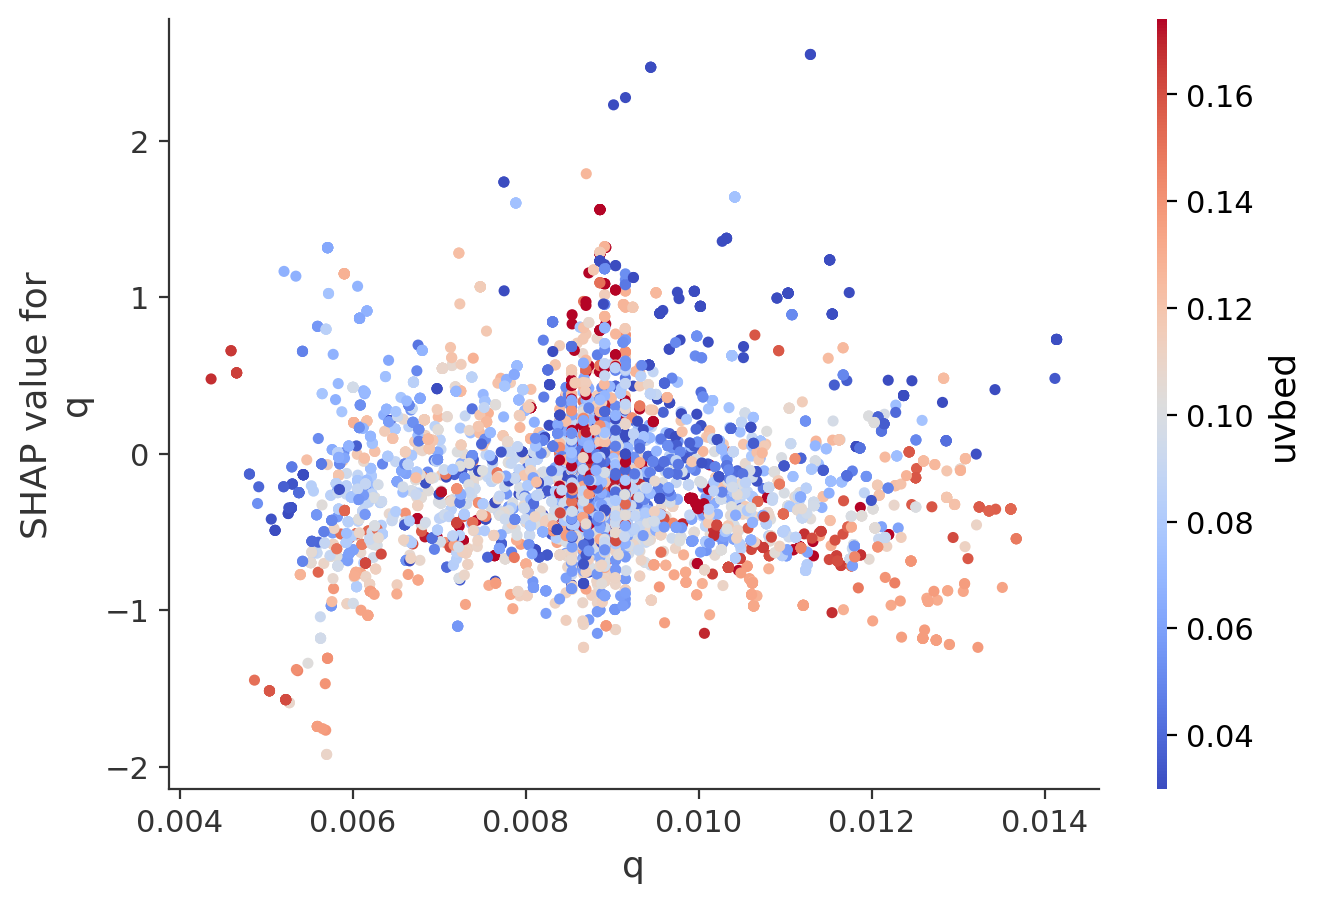

Feature: uvbedcs


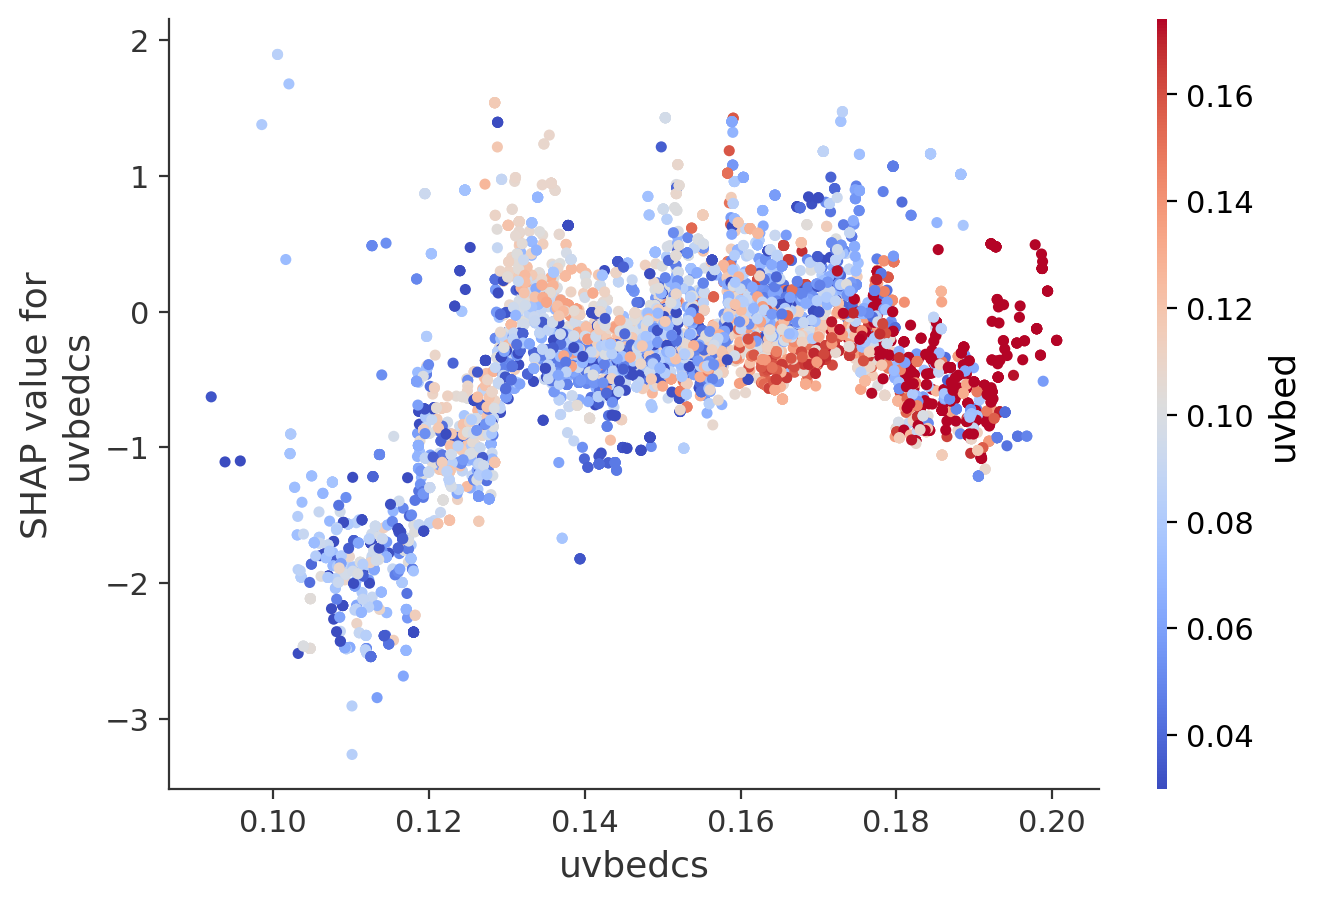

In [41]:
import shap
import matplotlib.pyplot as plt

# Transpose to (num_classes, num_samples, num_features)
shap_values_per_class = np.transpose(shap_values, (2, 0, 1))

# Define class names and features
class_names = ['0', '1', '2']
climate_features = ['t2m', 'uvbed', 'q', 'uvbedcs']

# Loop through each class
for target_class in range(len(class_names)):
    print(f"\n Dependence plots for Cluster: {class_names[target_class]}")
    
    # Loop through each climate feature
    for feature in climate_features:
        print(f"Feature: {feature}")
        
        shap.dependence_plot(
            feature,
            shap_values_per_class[target_class],       # SHAP values for this class
            X_test[climate_features],                  # Only climate features
            interaction_index='uvbed',                 # Interaction feature
            cmap=plt.cm.coolwarm                       # Custom color map
        )



 Analyzing SHAP peaks for Cluster: 0


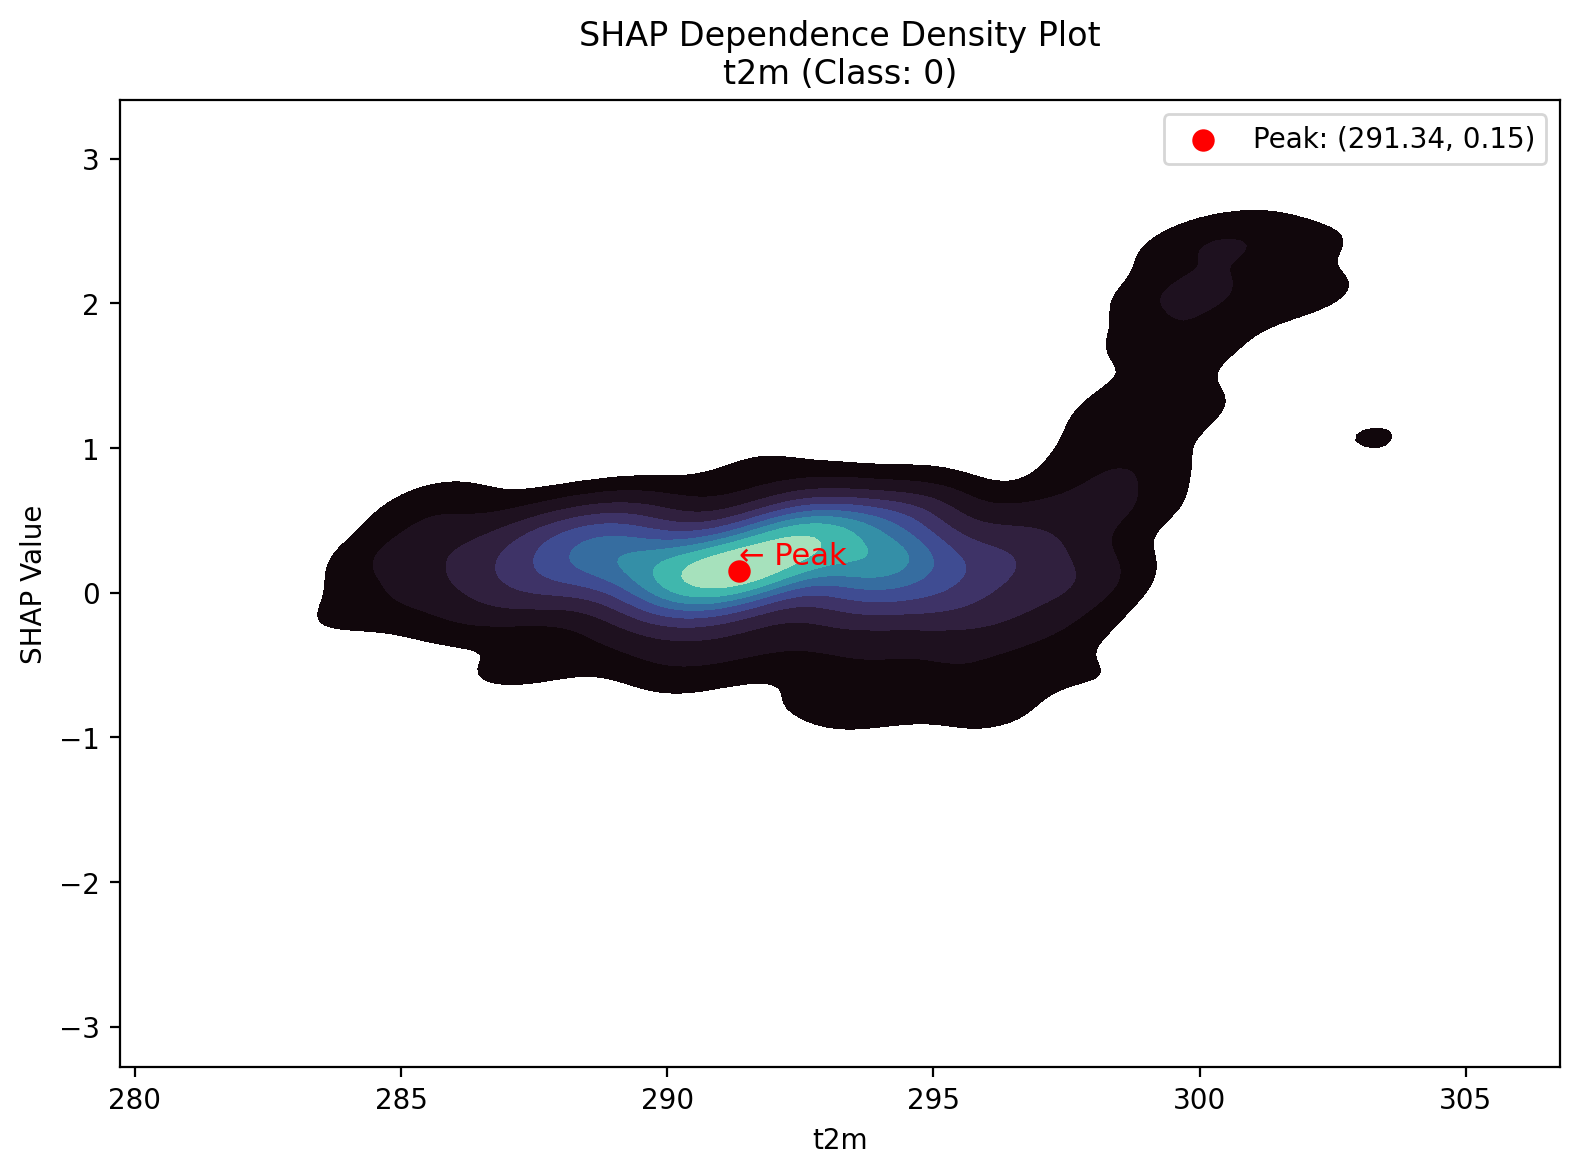

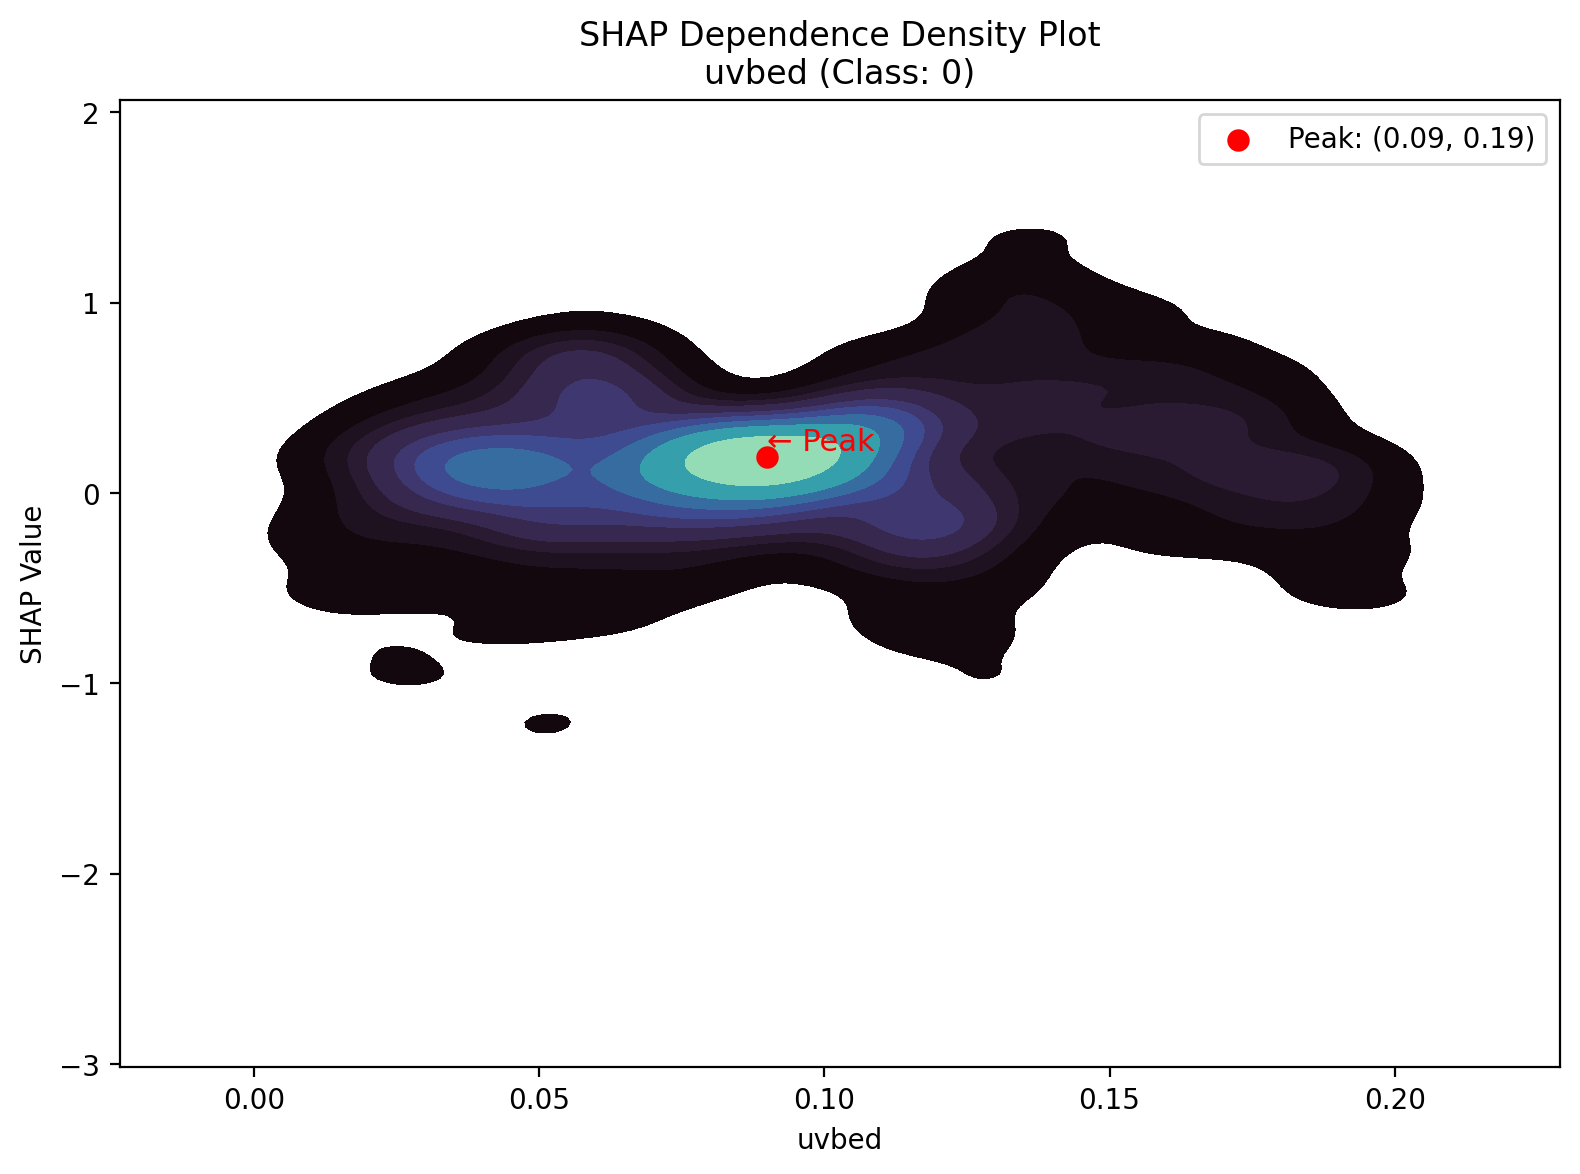

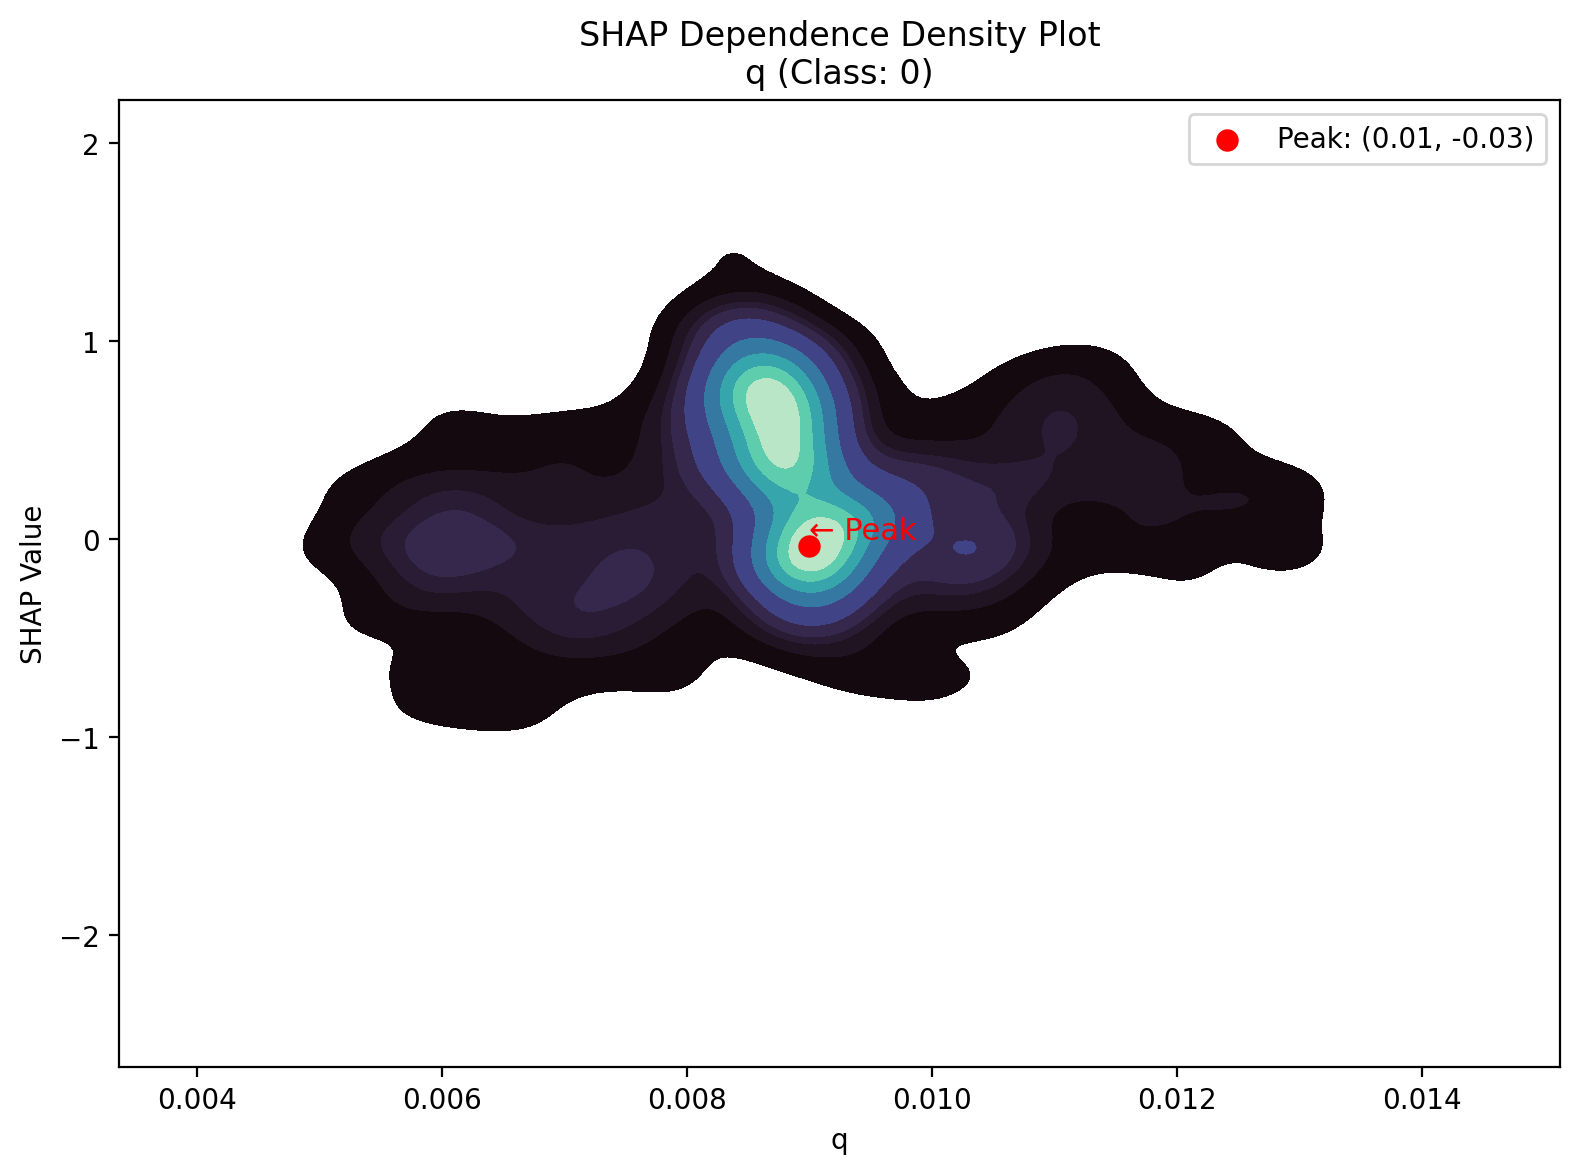

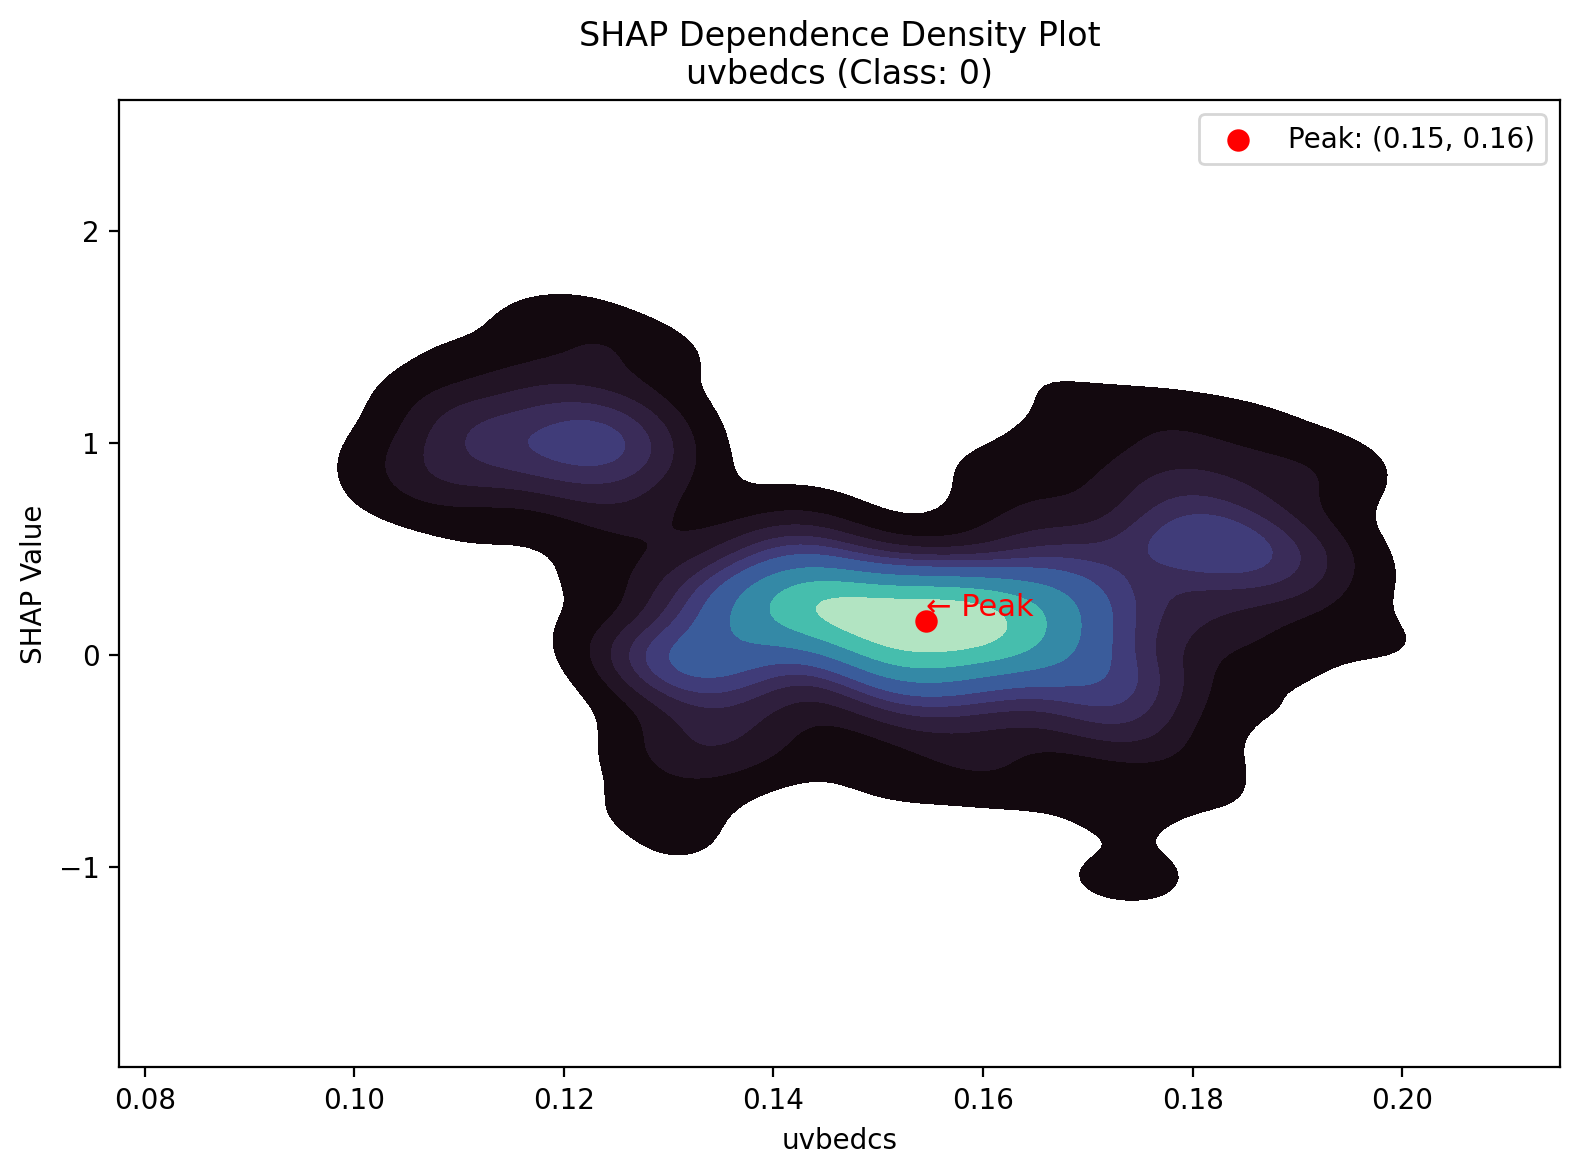


 Analyzing SHAP peaks for Cluster: 1


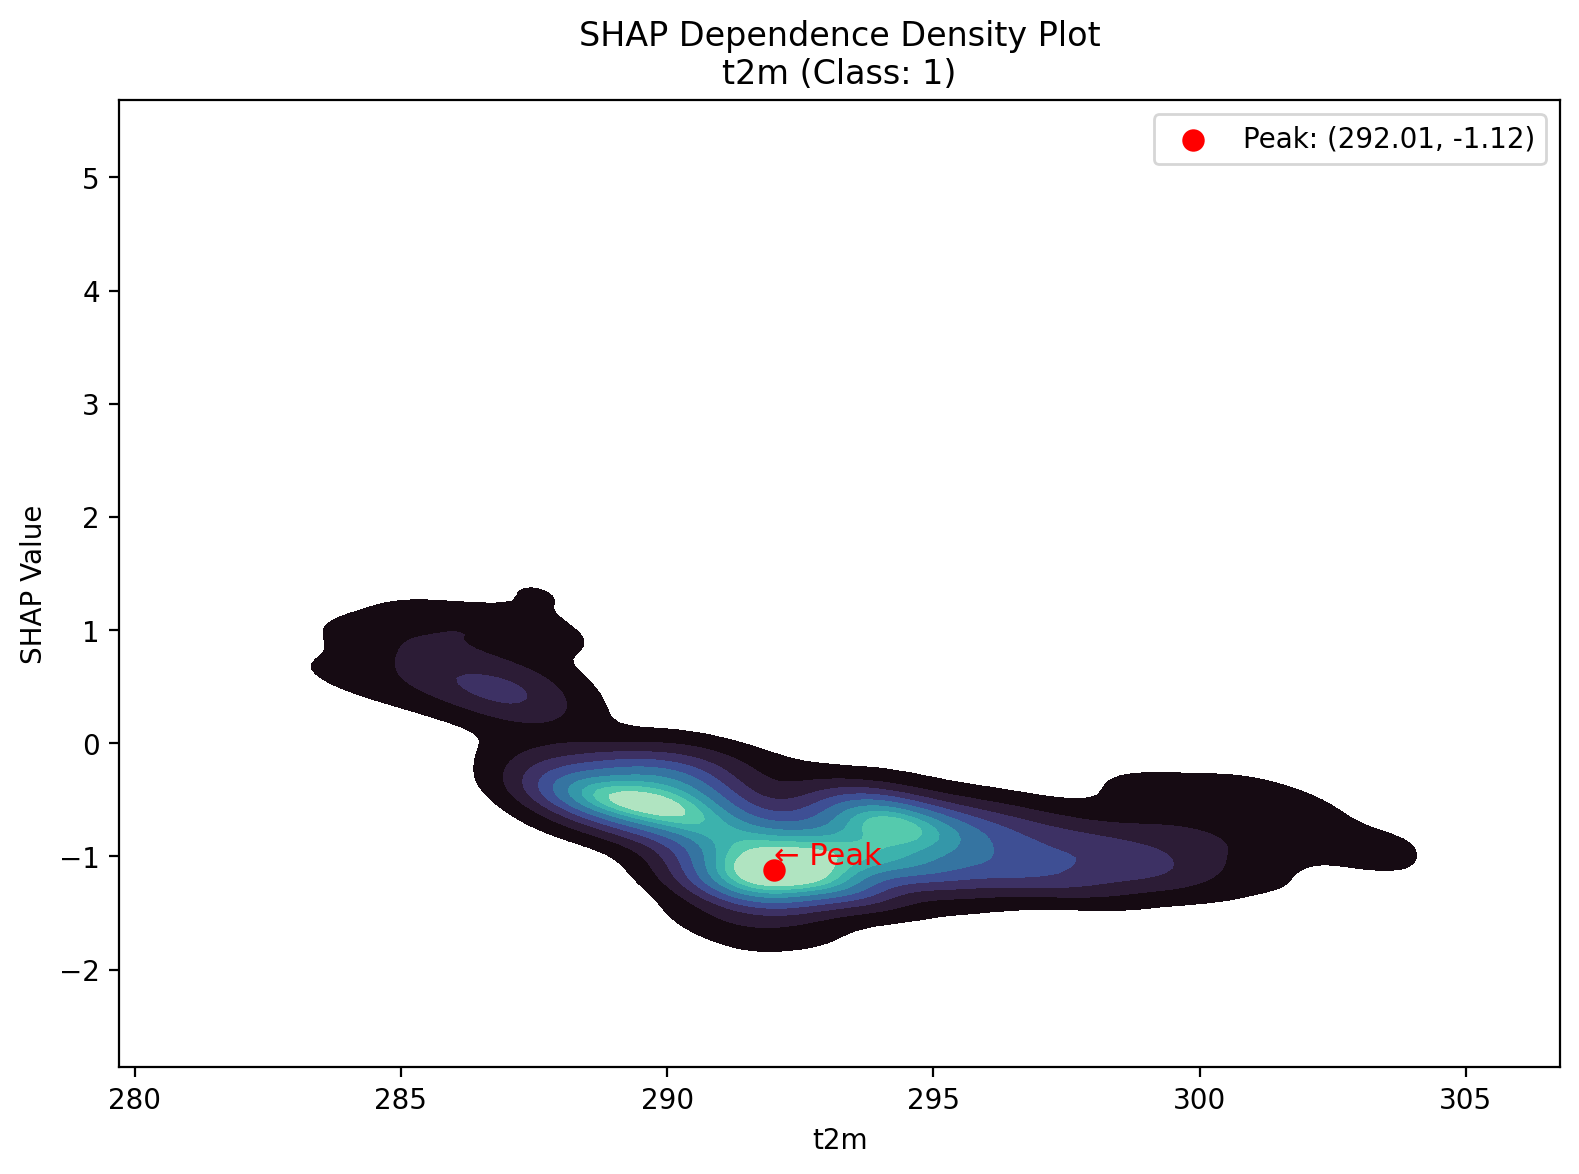

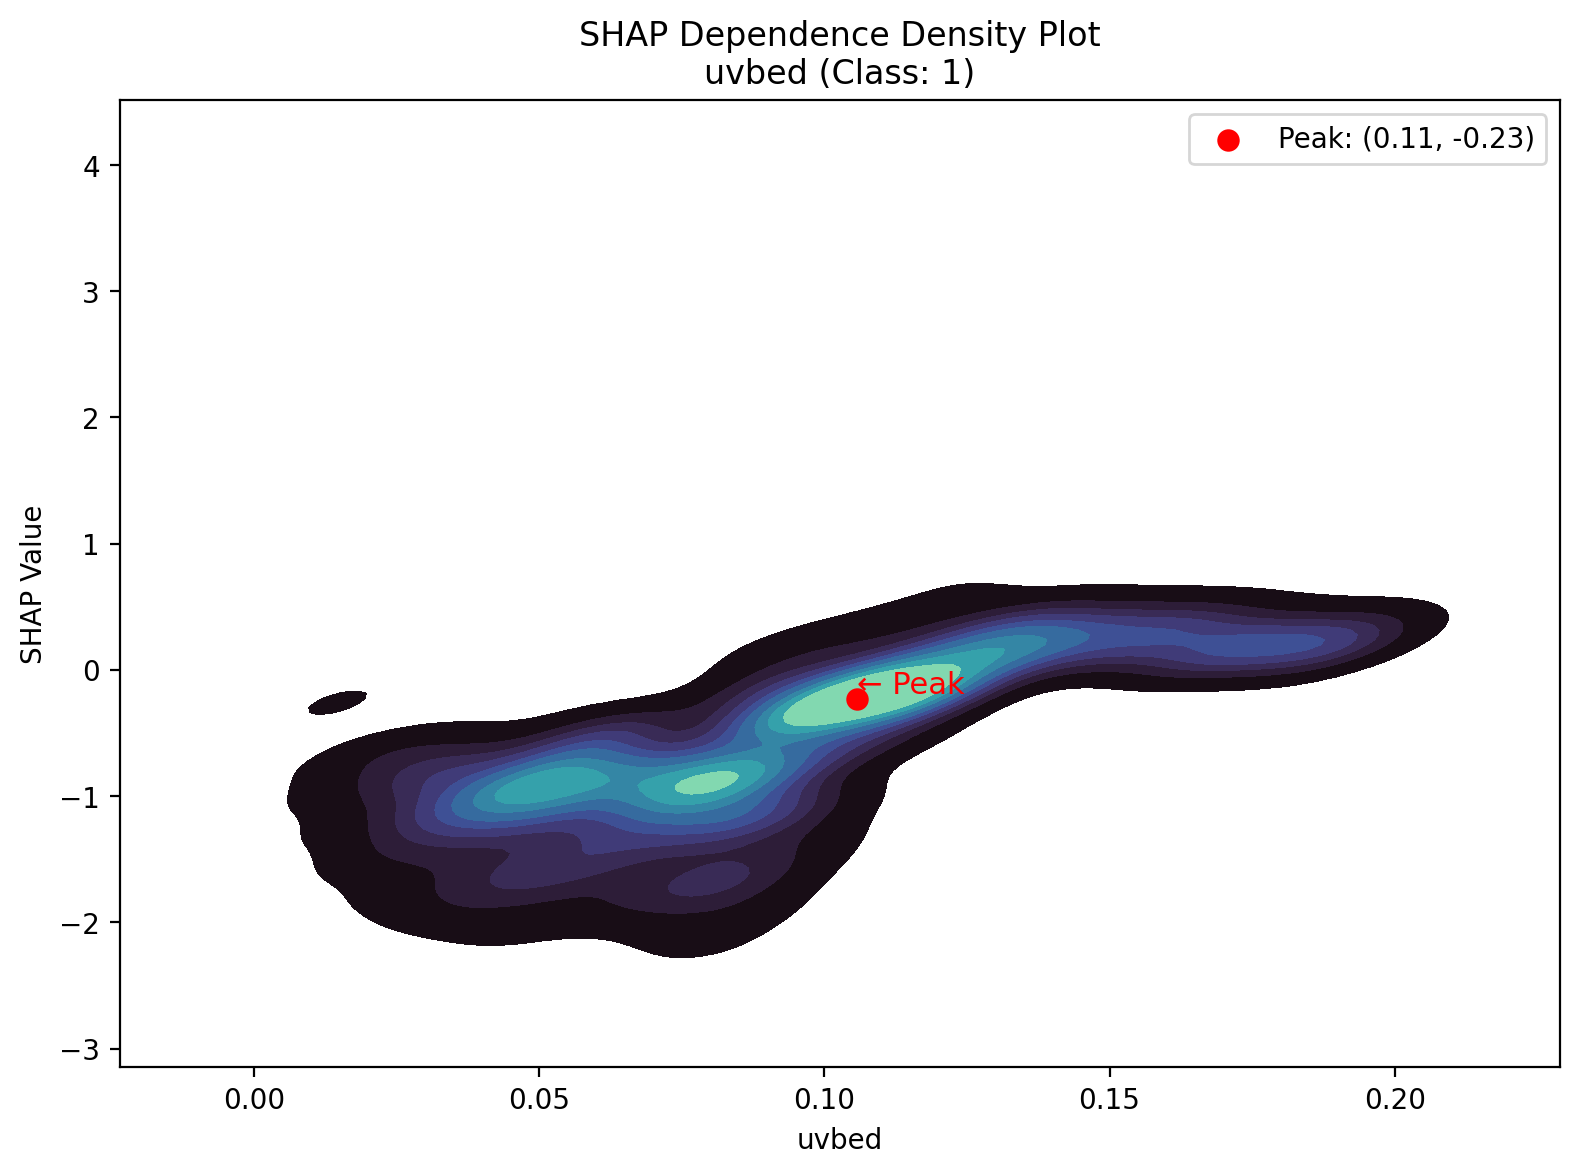

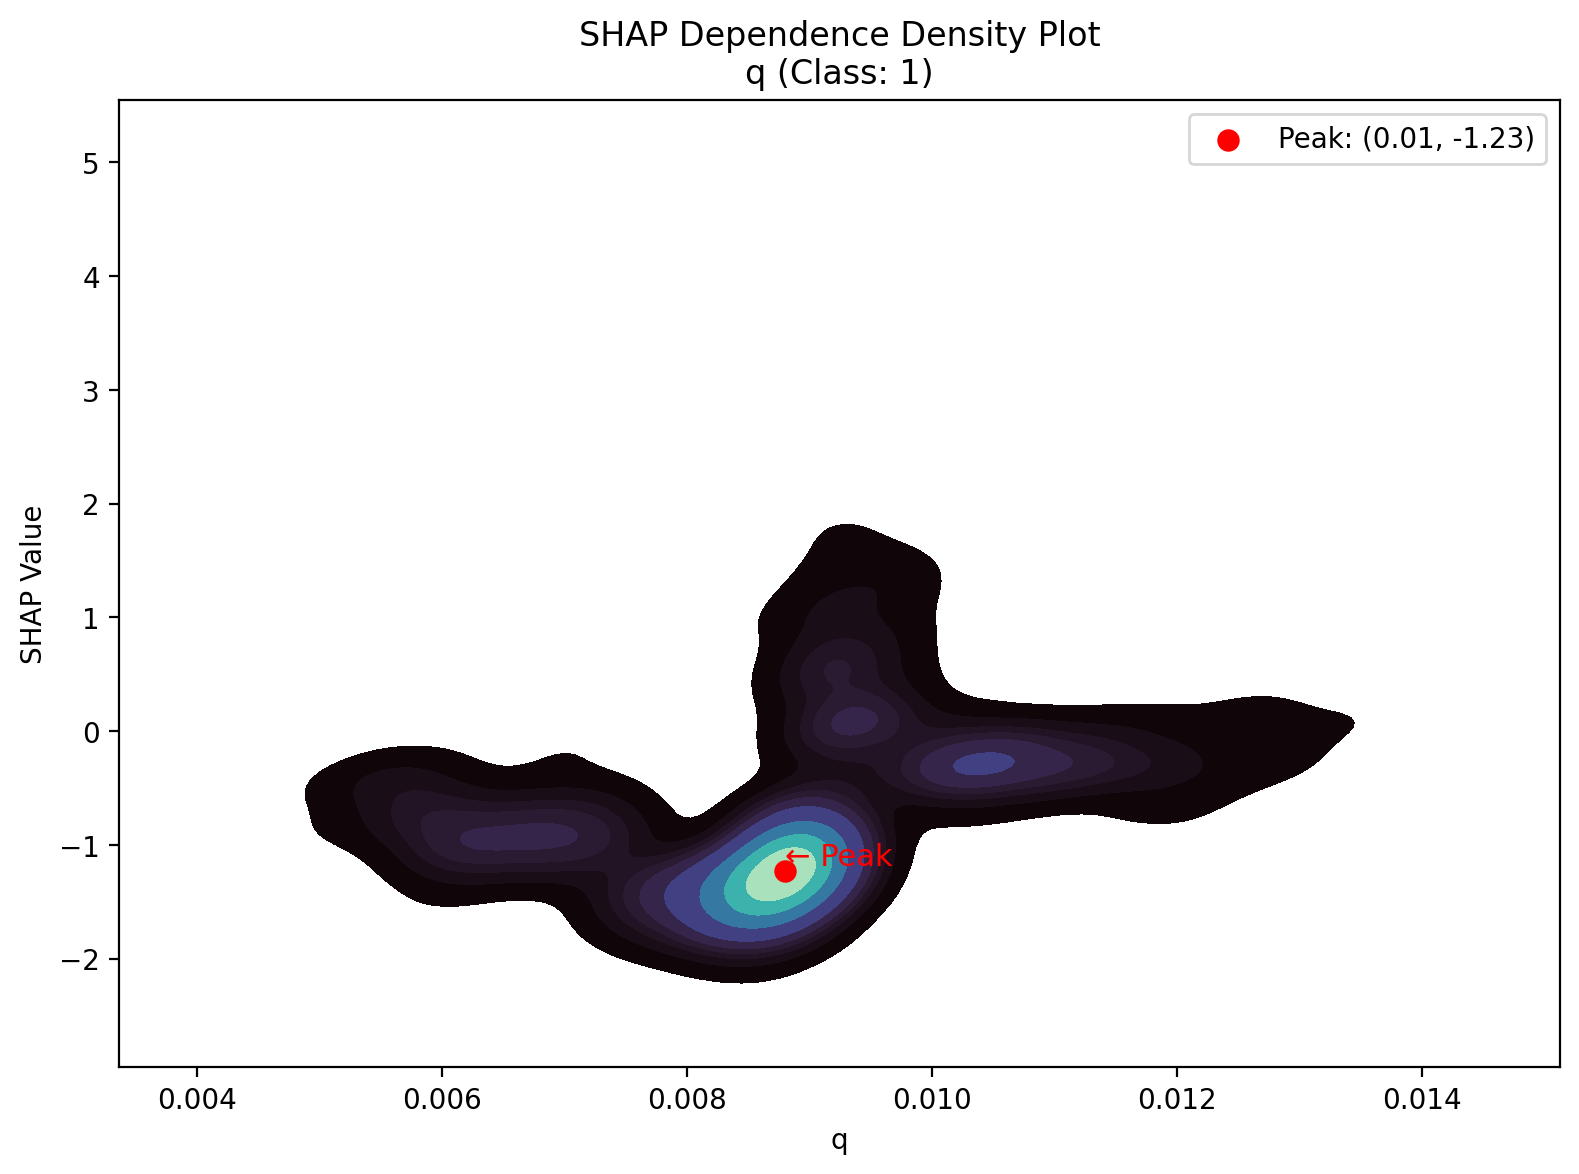

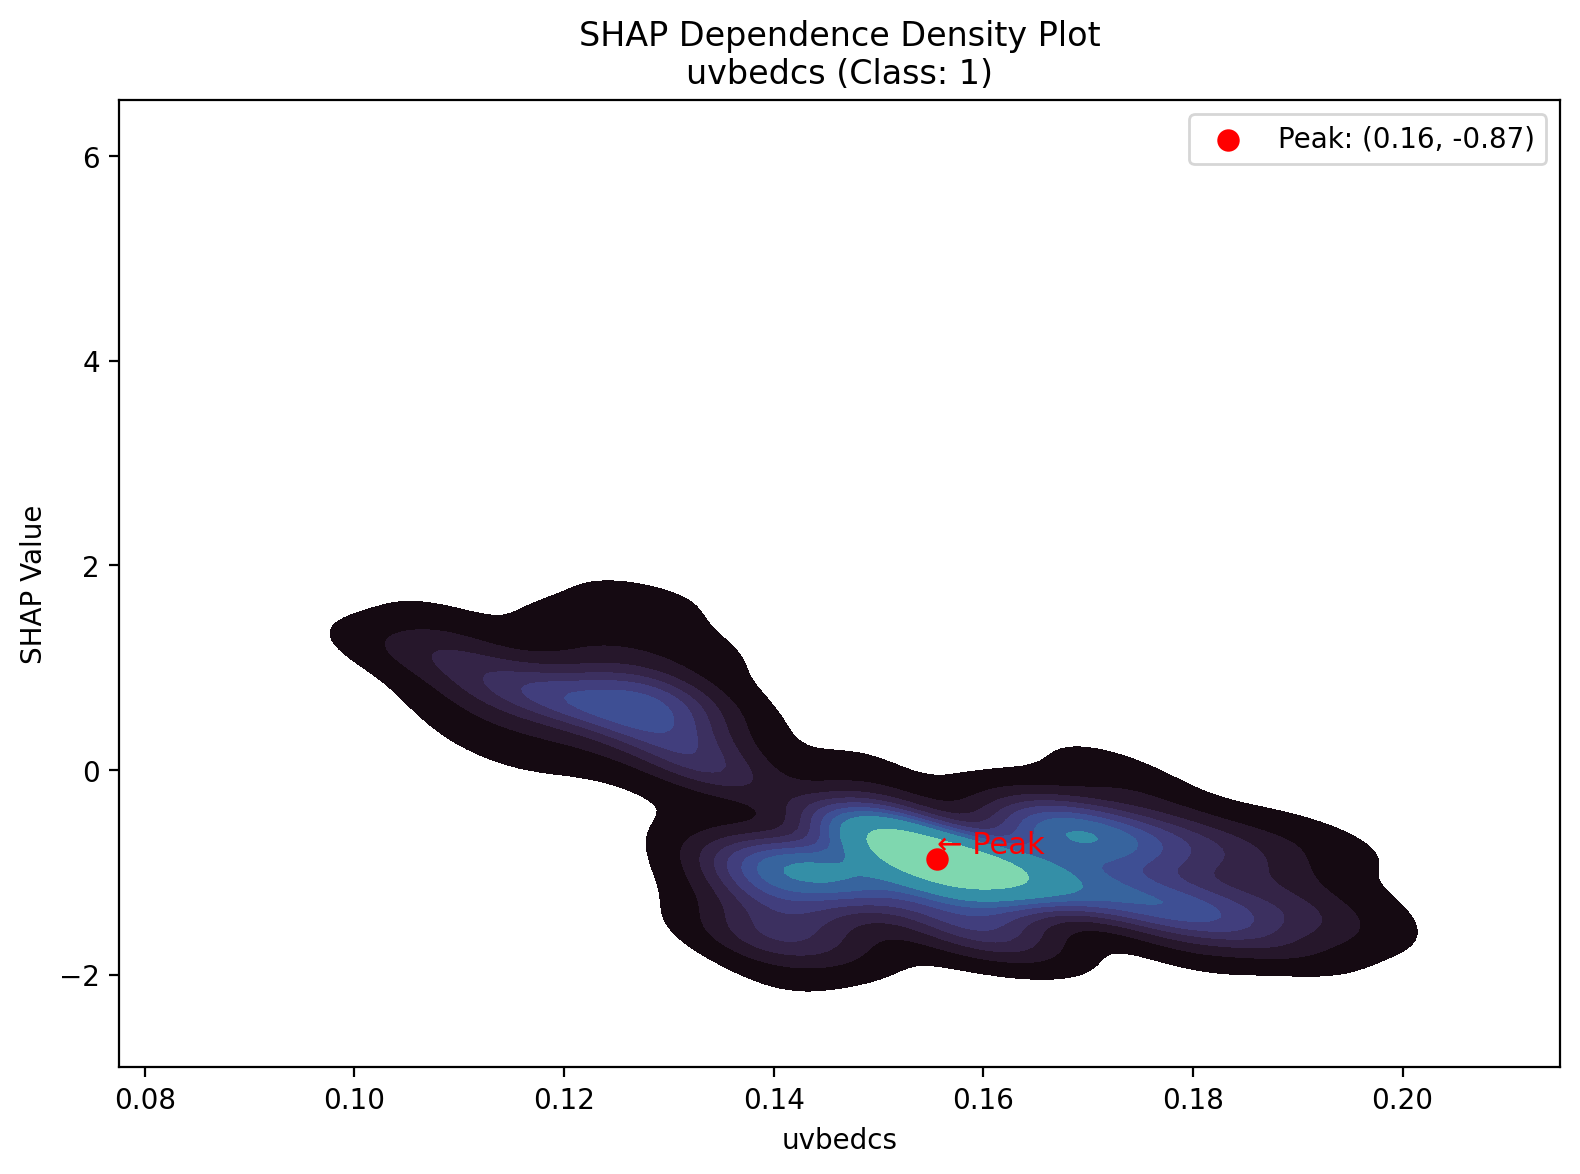


 Analyzing SHAP peaks for Cluster: 2


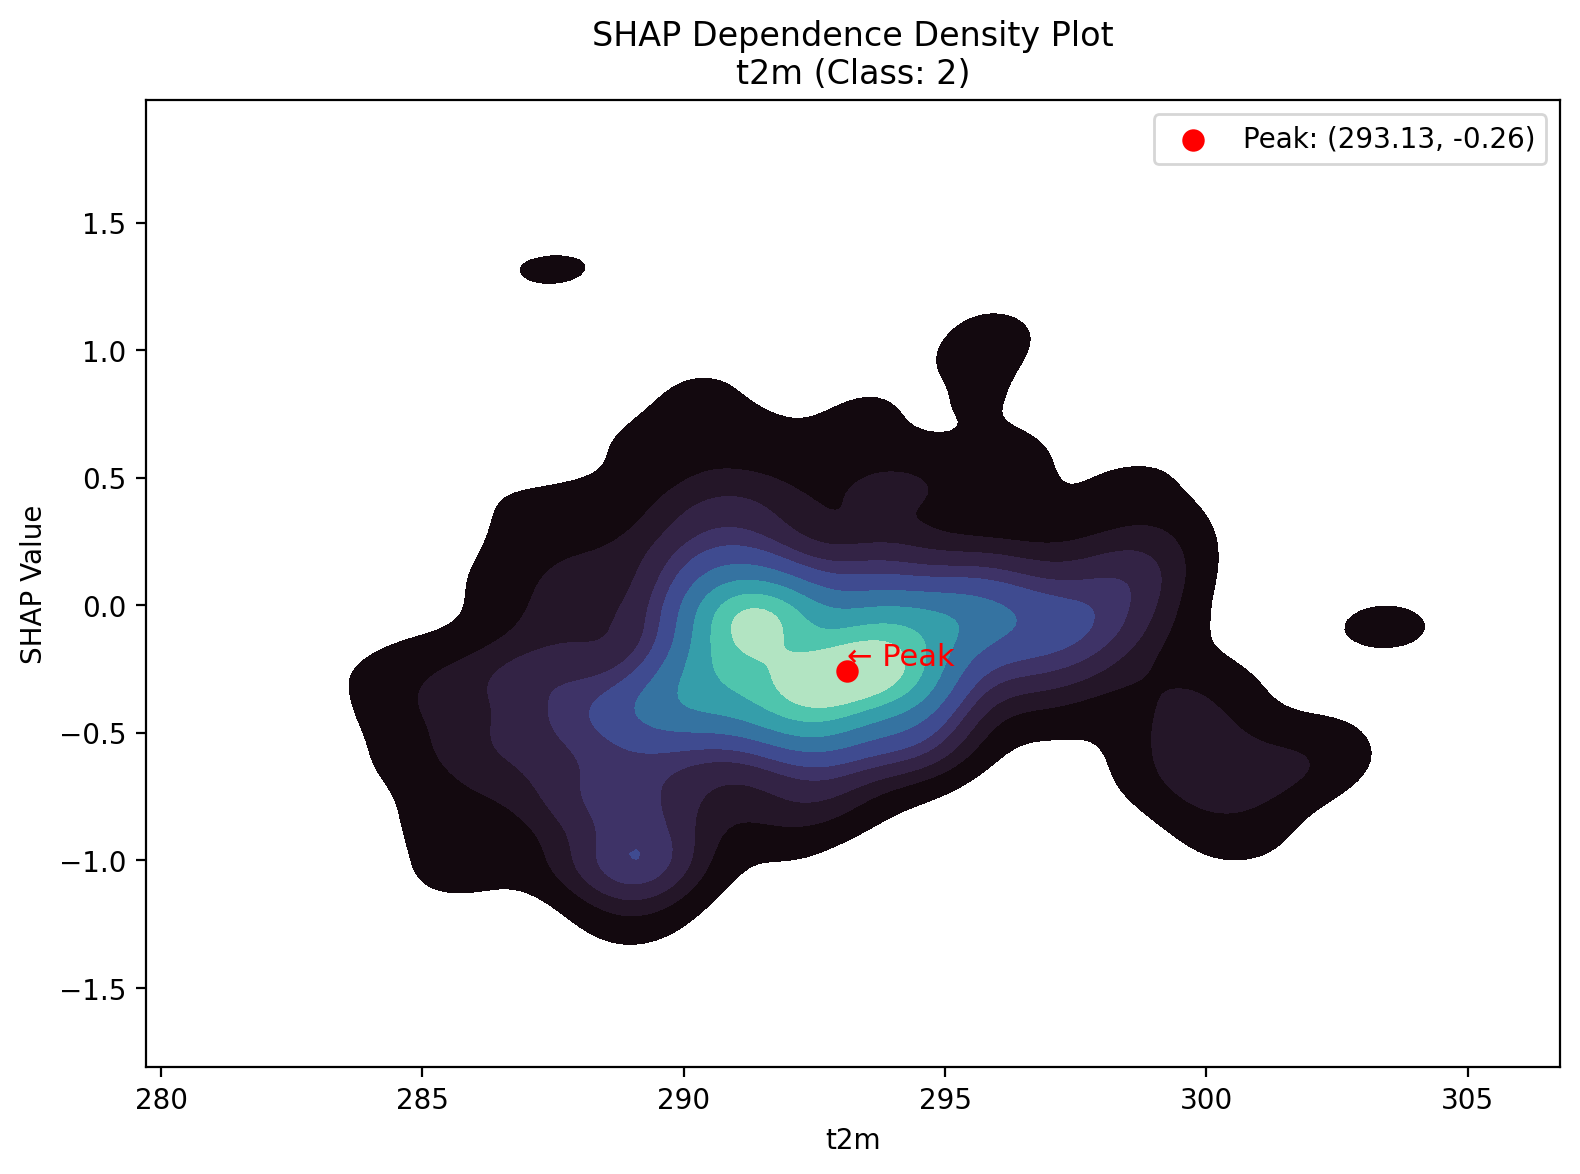

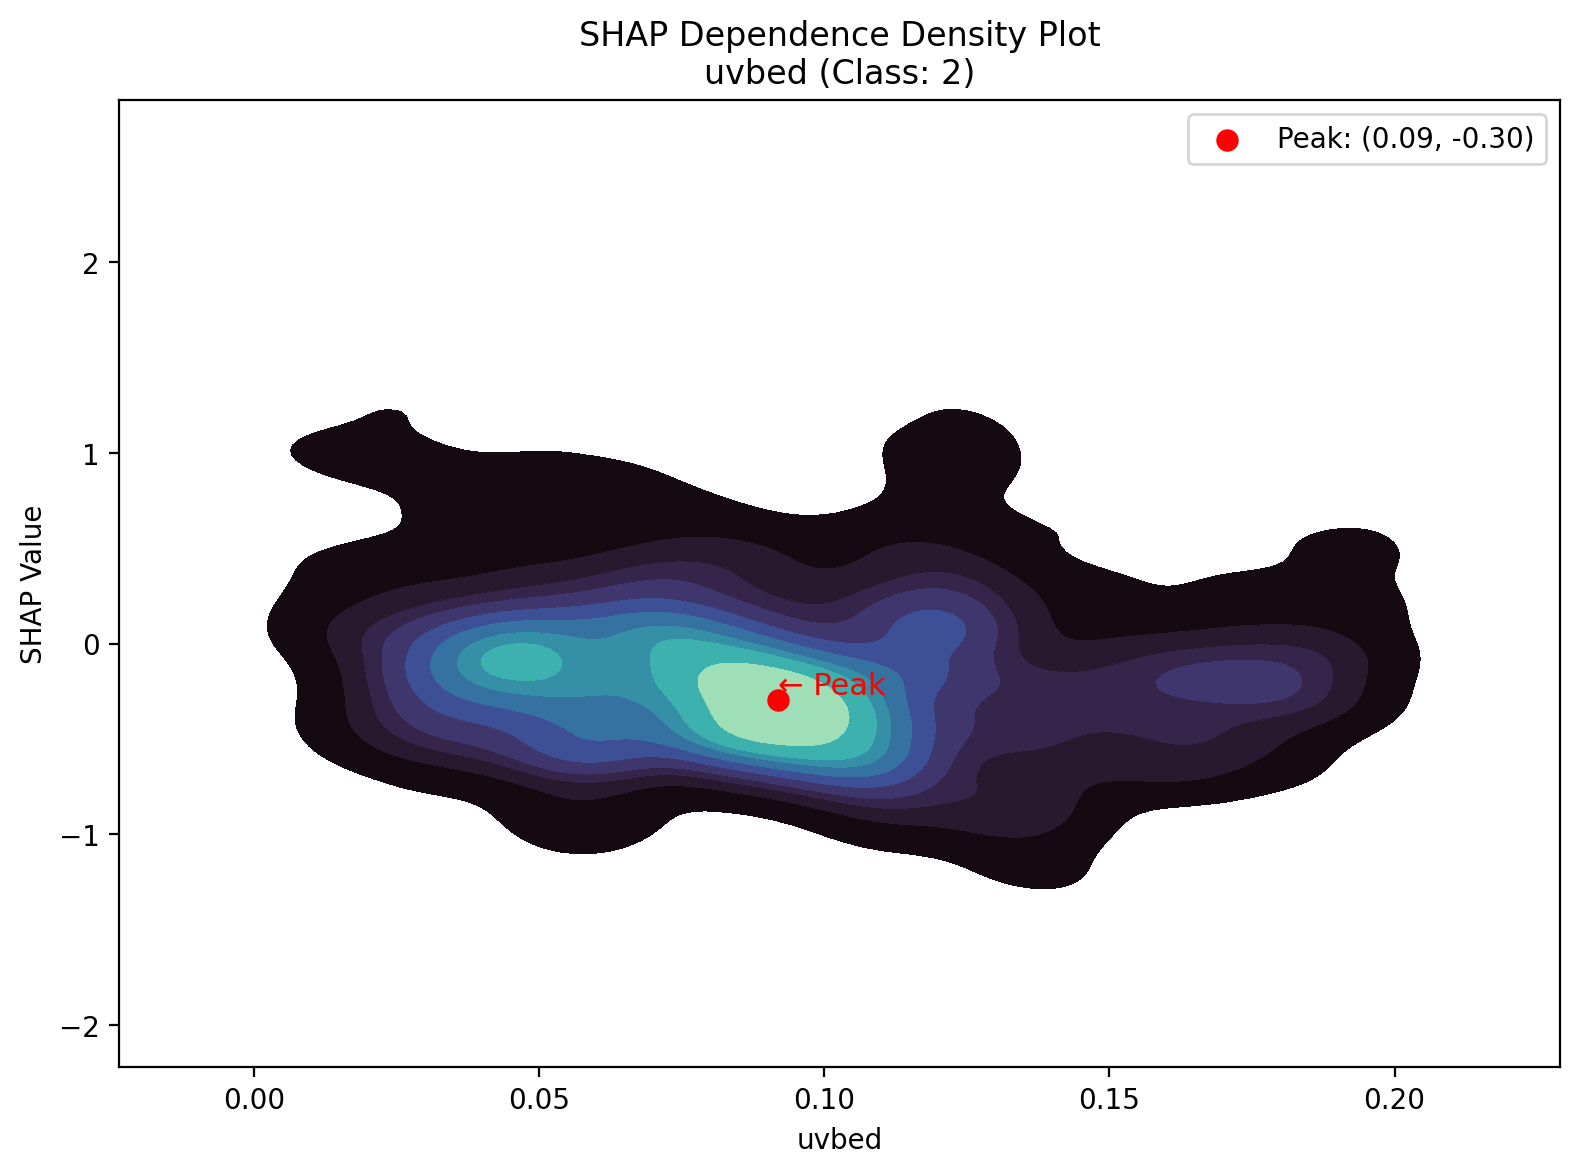

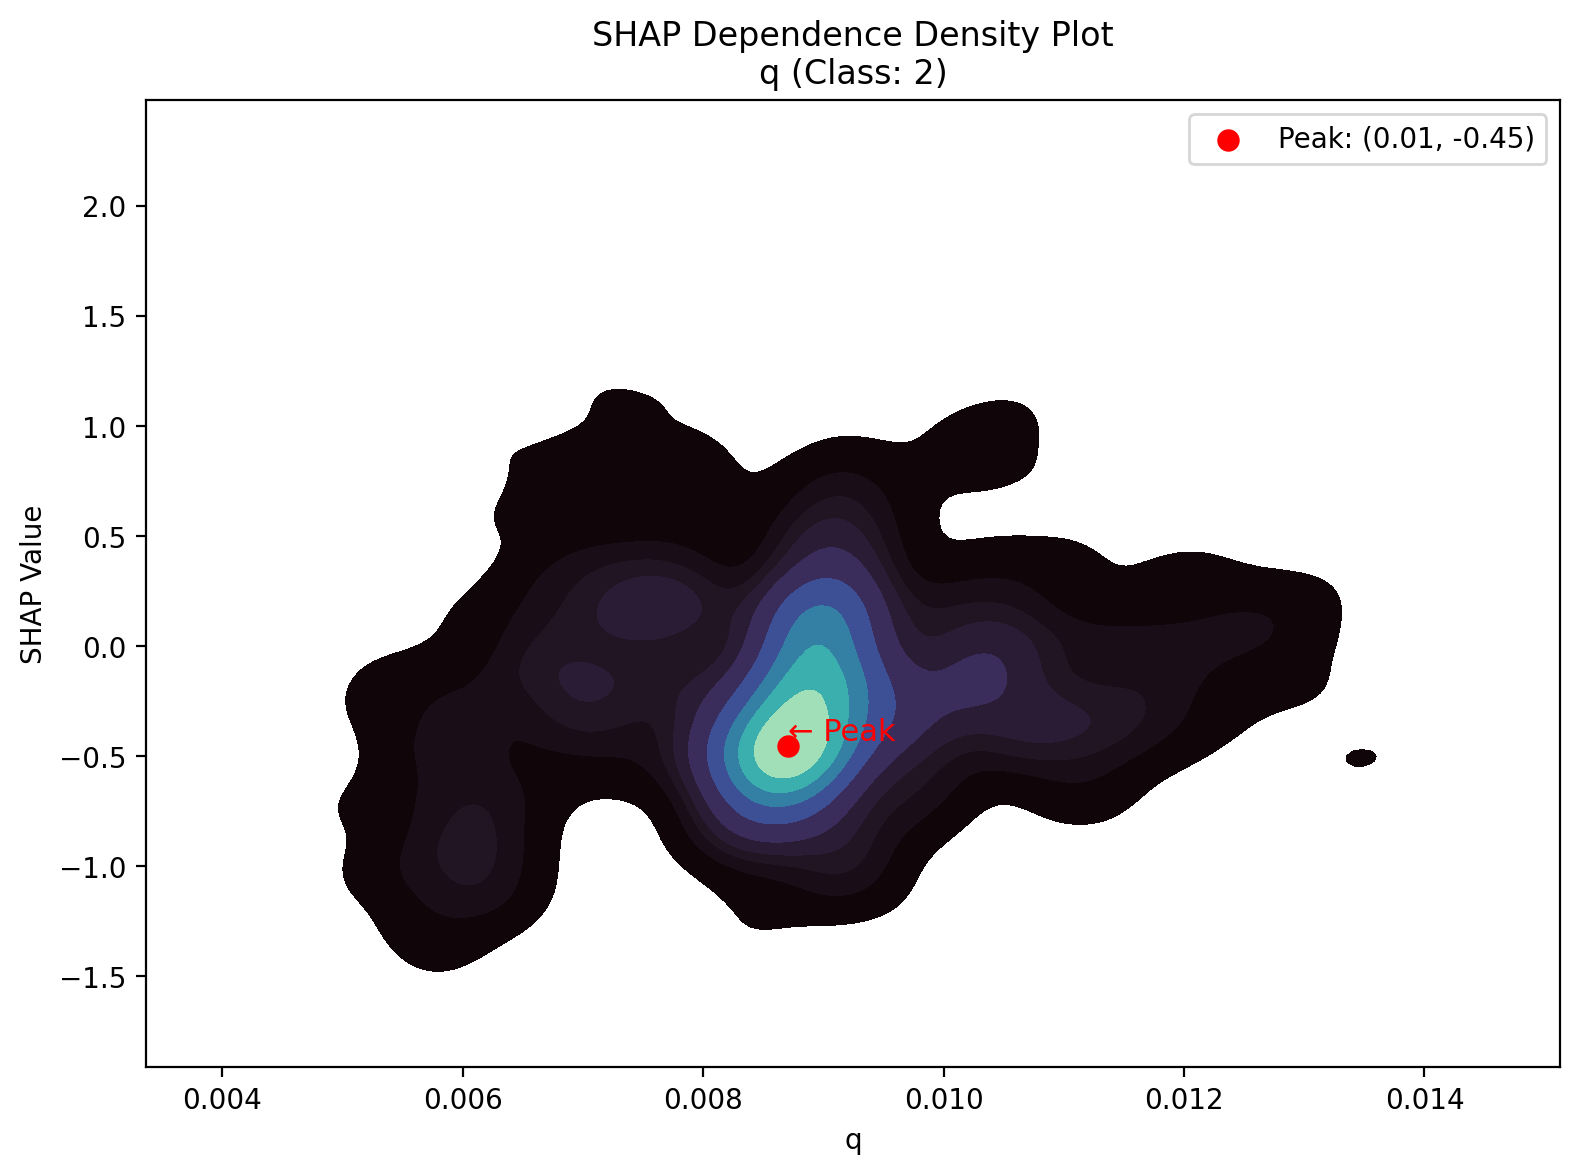

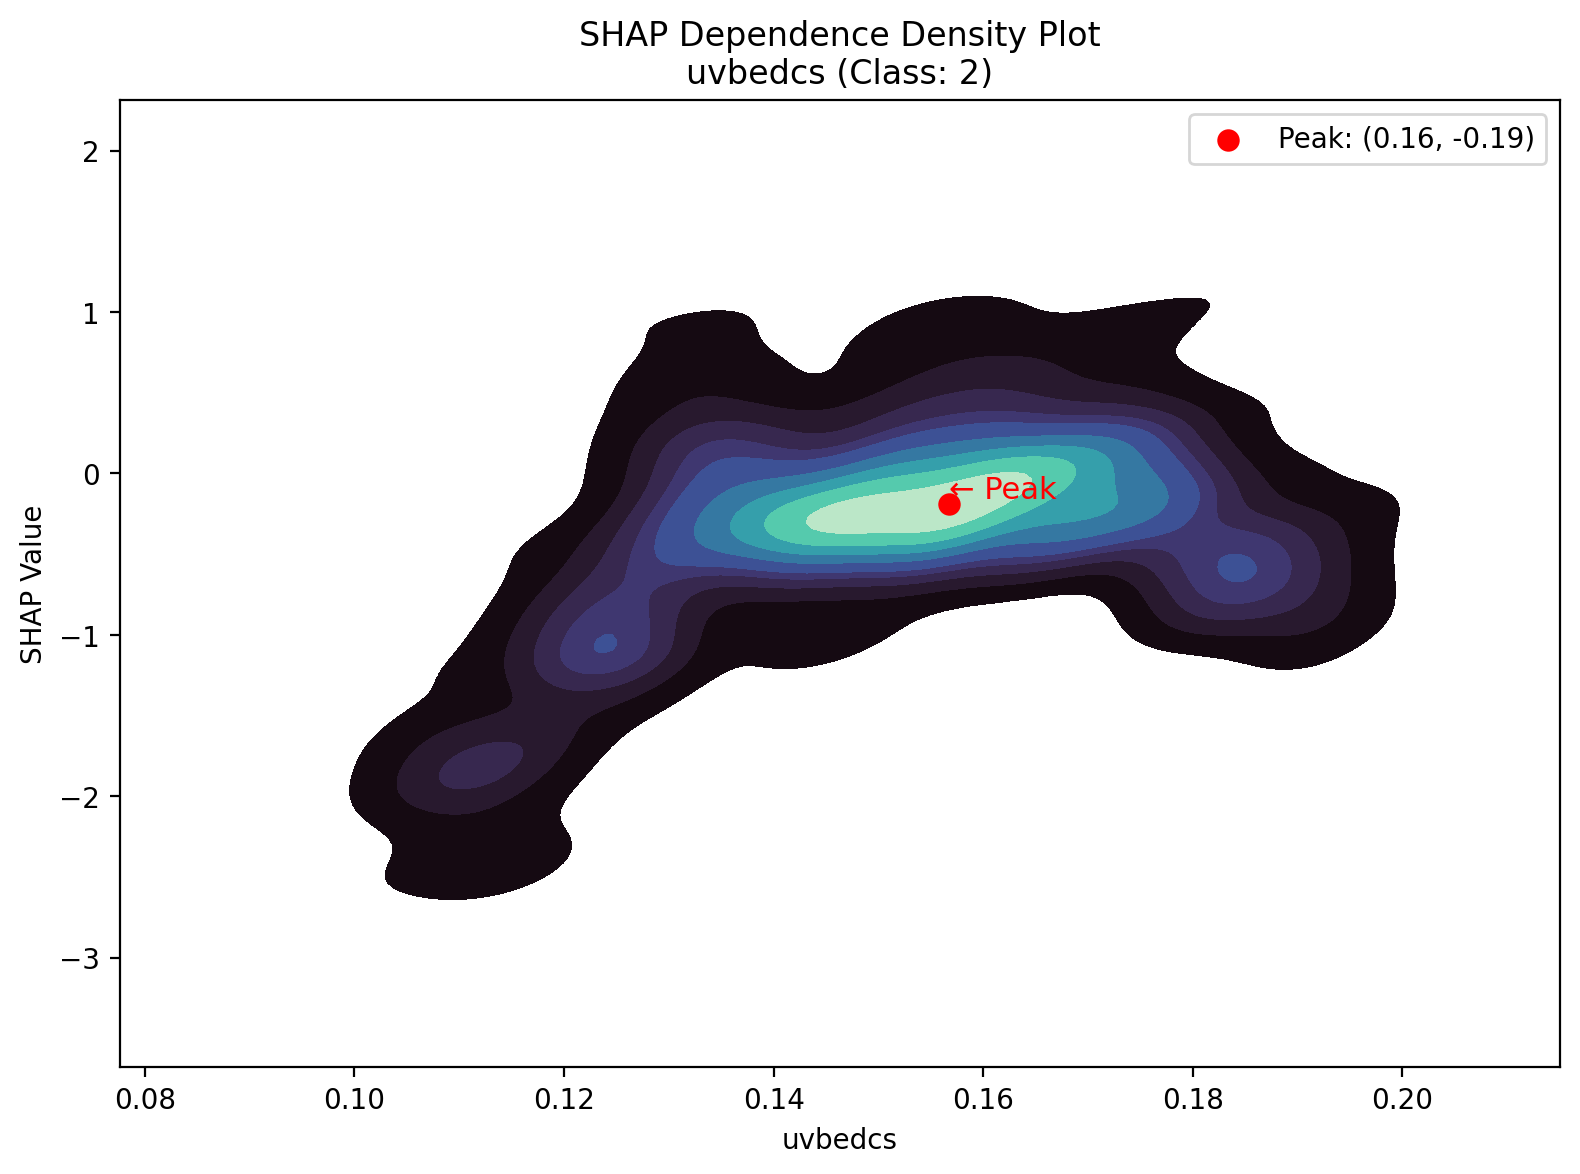

In [43]:
# Ensure SHAP values are in shape: (num_classes, num_samples, num_features)
shap_values_per_class = np.transpose(shap_values, (2, 0, 1))

# Define feature names and class labels
climate_features = ['t2m', 'uvbed', 'q', 'uvbedcs']
class_names = ['0', '1', '2']

# Loop through each class
for class_idx, class_name in enumerate(class_names):
    print(f"\n Analyzing SHAP peaks for Cluster: {class_name}")

    # Loop through each feature
    for feature in climate_features:
        feature_idx = X_test.columns.get_loc(feature)
        shap_feature_values = shap_values_per_class[class_idx][:, feature_idx]

        # Build DataFrame
        shap_df = pd.DataFrame({
            feature: X_test[feature].values,
            'shap_value': shap_feature_values
        })

        # Compute KDE
        x = shap_df[feature].values
        y = shap_df['shap_value'].values
        kde = gaussian_kde(np.vstack([x, y]))

        # Create grid for density estimation
        xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

        # Detect peak
        max_idx = np.argmax(zi)
        peak_x = xi.flatten()[max_idx]
        peak_y = yi.flatten()[max_idx]

        # Plot KDE with peak annotation
        plt.figure(figsize=(8, 6))
        sns.kdeplot(data=shap_df, x=feature, y='shap_value', fill=True, cmap="mako")
        plt.scatter(peak_x, peak_y, color='red', s=50, label=f"Peak: ({peak_x:.2f}, {peak_y:.2f})")
        plt.text(peak_x, peak_y, "← Peak", color='red', fontsize=11, va='bottom', ha='left')
        plt.title(f"SHAP Dependence Density Plot\n{feature} (Class: {class_name})")
        plt.xlabel(feature)
        plt.ylabel("SHAP Value")
        plt.legend()
        plt.tight_layout()
        plt.show()
